## 1. Importing Necessary Libraries

In [433]:
# Import packages
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
import itertools
import pickle
import warnings

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

In [434]:
warnings.filterwarnings('ignore')

## 2. Define Functions

This part is essential to measure the performance of a model : roc, cross validation, learning curve.

## 2.1 Confusion Matrix

The confusion matrix, also known as the error matrix, allows visualization of the performance of an algorithm :

In [ ]:
# Confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix"',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 2.2 Print all Metrics

In [ ]:
def print_metrics(y_train, y_test, y_pred_test, y_pred_train):
    print('Training Accuracy: ', accuracy_score(y_train, y_pred_train))
    print('Testing Accuracy: ', accuracy_score(y_test, y_pred_test))
    print('The Recall score: ', recall_score(y_test, y_pred_test))
    print('The Precision score: ', precision_score(y_test, y_pred_test))
    print('The F-1 score: ', f1_score(y_test, y_pred_test))
    print('-')
    print('Testing Confusion Matrix:')
    print(confusion_matrix(y_test,y_pred_test))
    print('-')
    print('Classification Report : ')
    print(classification_report(y_test,y_pred_test))
    print('-')
    print()

## 2.3 Plot Metrics

In [ ]:
def plot_metrics(model, X_train, y_train):
    N, train_score, test_score = learning_curve(model, X_train, y_train,
                                               cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1,1,10))
    plt.figure(figsize=(5,5))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, test_score.mean(axis=1), label='validation score')
    plt.legend()
    plt.show()

## 2.4 Plot Models Accuracy

In [ ]:
def plot_models_accuracy(model_names, accuracy_scores):
    models = pd.DataFrame({ 'Model': model_names, 'Score': accuracy_scores })
    models.sort_values(by='Score', ascending=False)
    plt.rcParams['figure.figsize'] = 15, 6
    sns.set_style("darkgrid")
    ax = sns.barplot(x=models.Model, y=models.Score, palette="rocket", saturation=1.5)
    plt.xlabel("Classifier Models", fontsize=20)
    plt.ylabel("% of Accuracy", fontsize=20)
    plt.title("Accuracy of different Classifier Models", fontsize=20)
    plt.xticks(fontsize=12, horizontalalignment='center', rotation=8)
    plt.yticks(fontsize=13)

    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height:.2%}', (x + width / 2, y + height * 1.02), ha='center', fontsize='x-large')

    plt.show()

## 2.5 Plot ROC

In [ ]:
# ROC curve
def plot_roc():
    plt.plot(fpr, tpr, label='ROC curve', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show();

## 2.6 Learning Curve

The Learning curve determines cross-validated training and test scores.

In [ ]:
# Learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

## 2.7 Cross Validation Metrics

Cross-validation is a technique to evaluate predictive models by partitioning the original sample into a training set to train the model, and a test set to evaluate it.

In [ ]:
# Cross val metric
def cross_val_metrics(model):
    scores = ['accuracy', 'precision', 'recall']
    for sc in scores:
        scores = cross_val_score(model, X, y, cv=5, scoring=sc)
        print('[%s] : %0.5f (+/- %0.5f)' % (sc, scores.mean(), scores.std()))

## 3. Import and Read Dataset

In [435]:
data = pd.read_csv(r'dataset_breast_cancer.csv')

# show the data of how many rows and columns
print("Data Shape - ", data.shape)

Data Shape -  (569, 33)


In [436]:
data.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [437]:
# description of the current data set
data.describe(include='all')

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.037183e+07,NaN,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,NaN,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,NaN,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,NaN,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,NaN,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,NaN,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN


From the first look in the data description we can see that :
     - B = benign is the most frequent value in our target columns
     - Unnamed: 32nd columns is an empty column

In [438]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

According to the data, all features are numerical values except the target value diagnosis which is an object: M = malignant, B = benign.

# 4. EDA (Exploratory Data Analysis)

## 4.1 Drop Out Unnecessary Column

As the 32nd colum is empty, we will drop it out.

In [439]:
data = data.drop('Unnamed: 32', axis=1)

## 4.2 Check the Missing Value

In [440]:
missing_values = data.isnull().sum()
percent_missing = data.isnull().sum() / data.shape[0] * 100

value = {
    'missing_values ': missing_values,
    'percent_missing %': percent_missing
}

frame = pd.DataFrame(value)
frame

,missing_values,percent_missing %
id,0,0.0
diagnosis,0,0.0
radius_mean,0,0.0
texture_mean,0,0.0
perimeter_mean,0,0.0
area_mean,0,0.0
smoothness_mean,0,0.0
compactness_mean,0,0.0
concavity_mean,0,0.0
concave points_mean,0,0.0


From the tables, it shows that the data is cleaned and no missing value.

In [441]:
# transformation of type of the target value to numerical
le = preprocessing.LabelEncoder()
data.diagnosis = le.fit_transform(data.diagnosis)
data.diagnosis

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int32

Diagnosis:

M = malignant => 1
B = benign => 0

Let's also drop out an id column since we also don't need it.

In [442]:
# drop the id columns
data = data.drop('id', axis=1)

## 4.3 Correlation Matrix with Heatmap

A graphical representation of a correlation matrix representing the correlation between different variables. The value of correlation can take any value
from -1 to 1.

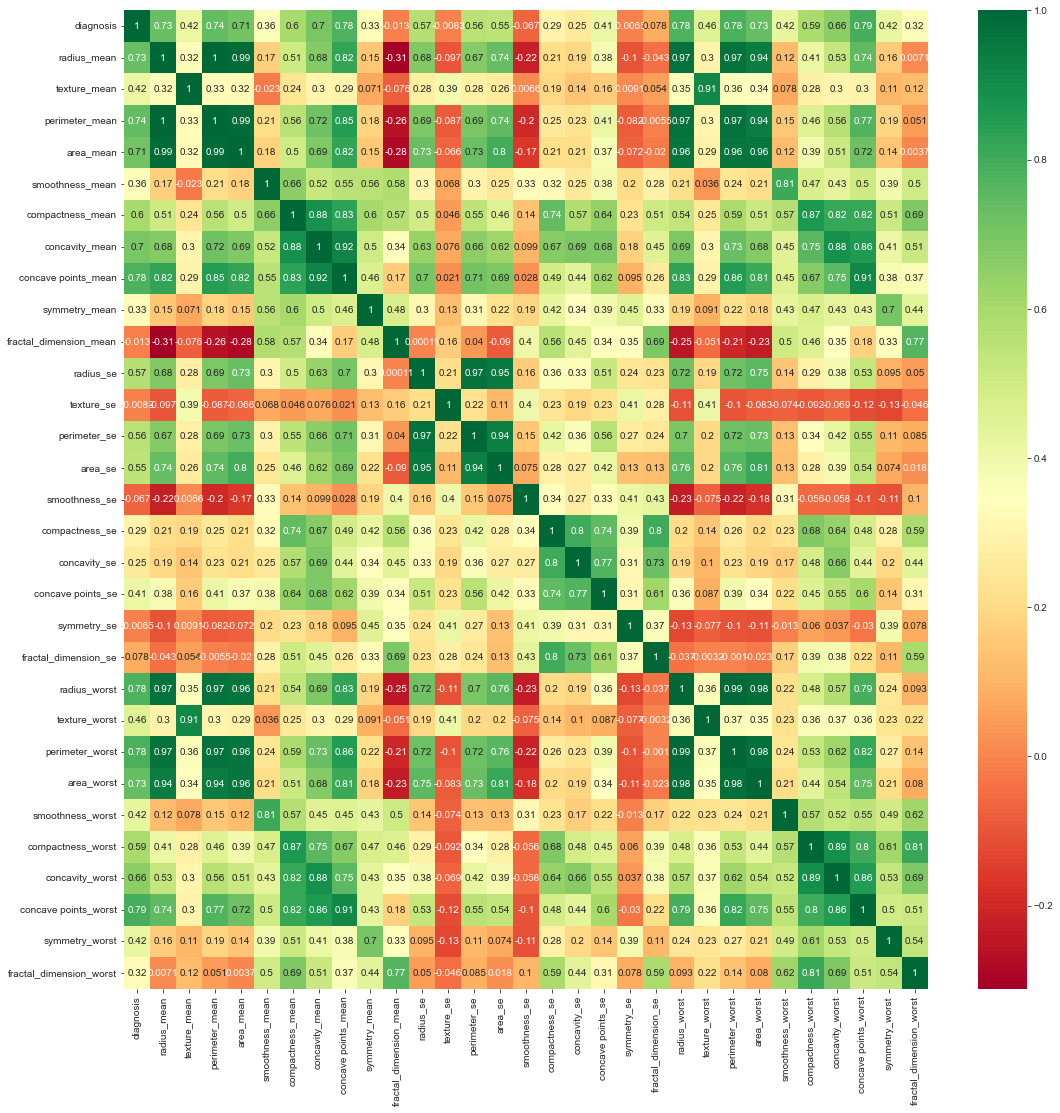

In [443]:
#independent columns
X = data.iloc[:, 0:20]
#target column
y = data.iloc[:, -1]

#get correlations of each features in dataset
corrmatrix = data.corr()
top_corr_features = corrmatrix.index
plt.figure(figsize=(18, 18))

#plot heat map
g = sns.heatmap(data[top_corr_features].corr(), annot=True, cmap="RdYlGn")

From the above correlation heatmap, we could get some of the following information:

- Variables such as radius_worst & radious_mean, radius_worst & parameter_mean, are having strong positive correlation, just to name a few.
- Variables such as radius_worst & smoothness_se, and fractal_dimension_mean & radious_mean are having strong negative correlations: also, just to name a few.
- overall, to view this correlation graph: there are several variables that have no correlation and whose correlation value is near 0, while whose that have strong correlation is closer to 1.

## 4.4 Positive Correlated Features

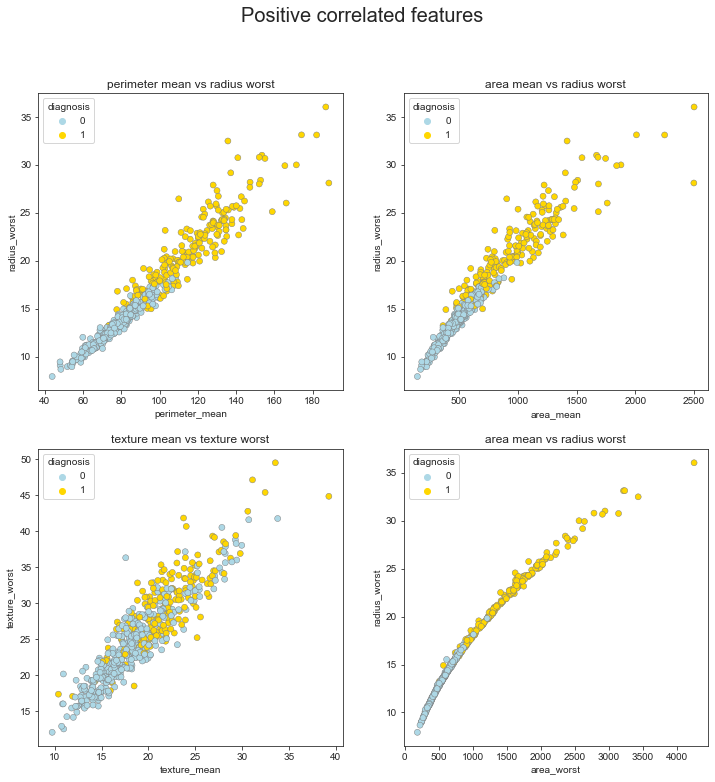

In [444]:
# B = benign => 0
# M = malignant => 1
palette = {0: 'lightblue', 1: 'gold'}
edgecolor = 'grey'

# Plot +
fig = plt.figure(figsize=(12, 12))

plt.subplot(221)
ax1 = sns.scatterplot(x=data['perimeter_mean'], y=data['radius_worst'], hue="diagnosis",
                      data=data, palette=palette, edgecolor=edgecolor)
plt.title('perimeter mean vs radius worst')
plt.subplot(222)
ax2 = sns.scatterplot(x=data['area_mean'], y=data['radius_worst'], hue="diagnosis",
                      data=data, palette=palette, edgecolor=edgecolor)
plt.title('area mean vs radius worst')
plt.subplot(223)
ax3 = sns.scatterplot(x=data['texture_mean'], y=data['texture_worst'], hue="diagnosis",
                      data=data, palette=palette, edgecolor=edgecolor)
plt.title('texture mean vs texture worst')
plt.subplot(224)
ax4 = sns.scatterplot(x=data['area_worst'], y=data['radius_worst'], hue="diagnosis",
                      data=data, palette=palette, edgecolor=edgecolor)
plt.title('area mean vs radius worst')

fig.suptitle('Positive correlated features', fontsize=20)
plt.savefig('1')
plt.show()

## 4.5 Uncorrelated Features

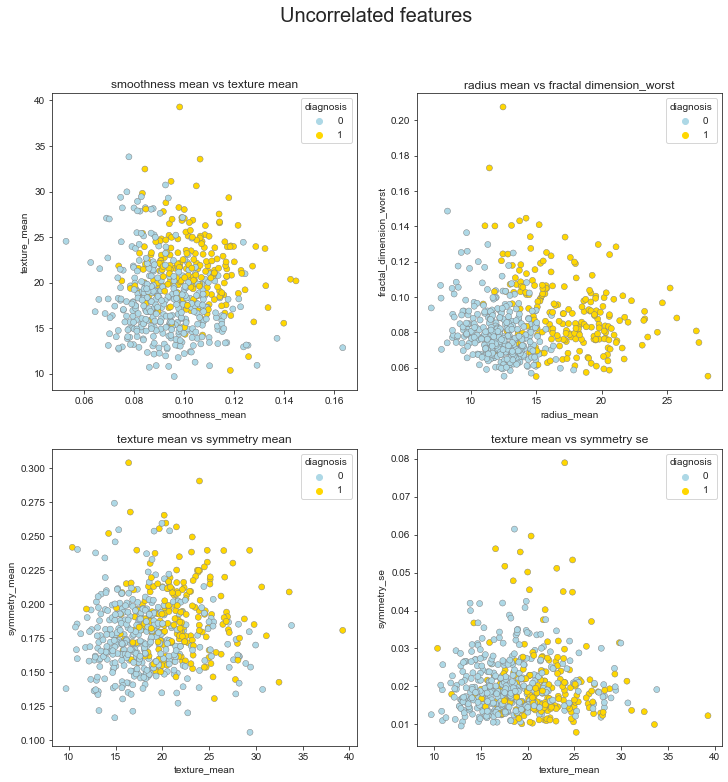

In [445]:
# B = benign => 0
# M = malignant => 1

fig = plt.figure(figsize=(12, 12))

plt.subplot(221)
ax1 = sns.scatterplot(x=data['smoothness_mean'], y=data['texture_mean'], hue="diagnosis",
                      data=data, palette=palette, edgecolor=edgecolor)
plt.title('smoothness mean vs texture mean')
plt.subplot(222)
ax2 = sns.scatterplot(x=data['radius_mean'], y=data['fractal_dimension_worst'], hue="diagnosis",
                      data=data, palette=palette, edgecolor=edgecolor)
plt.title('radius mean vs fractal dimension_worst')
plt.subplot(223)
ax3 = sns.scatterplot(x=data['texture_mean'], y=data['symmetry_mean'], hue="diagnosis",
                      data=data, palette=palette, edgecolor=edgecolor)
plt.title('texture mean vs symmetry mean')
plt.subplot(224)
ax4 = sns.scatterplot(x=data['texture_mean'], y=data['symmetry_se'], hue="diagnosis",
                      data=data, palette=palette, edgecolor=edgecolor)
plt.title('texture mean vs symmetry se')

fig.suptitle('Uncorrelated features', fontsize=20)
plt.savefig('2')
plt.show()

## 4.6 Negative Correlated Features

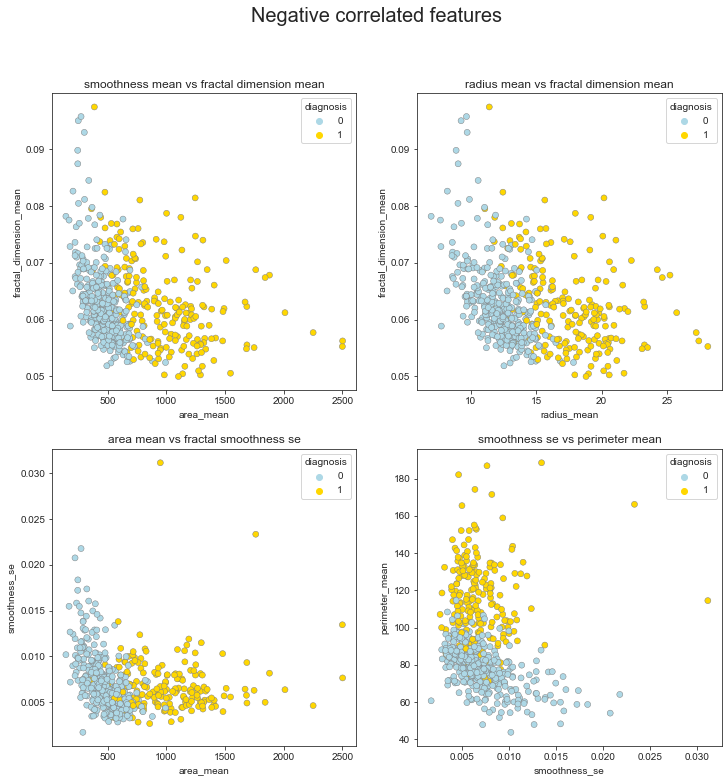

In [446]:
# B = benign => 0
# M = malignant => 1

fig = plt.figure(figsize=(12, 12))

plt.subplot(221)
ax1 = sns.scatterplot(x=data['area_mean'], y=data['fractal_dimension_mean'], hue="diagnosis",
                      data=data, palette=palette, edgecolor=edgecolor)
plt.title('smoothness mean vs fractal dimension mean')
plt.subplot(222)
ax2 = sns.scatterplot(x=data['radius_mean'], y=data['fractal_dimension_mean'], hue="diagnosis",
                      data=data, palette=palette, edgecolor=edgecolor)
plt.title('radius mean vs fractal dimension mean')
plt.subplot(223)
ax2 = sns.scatterplot(x=data['area_mean'], y=data['smoothness_se'], hue="diagnosis",
                      data=data, palette=palette, edgecolor=edgecolor)
plt.title('area mean vs fractal smoothness se')
plt.subplot(224)
ax2 = sns.scatterplot(x=data['smoothness_se'], y=data['perimeter_mean'], hue="diagnosis",
                      data=data, palette=palette, edgecolor=edgecolor)
plt.title('smoothness se vs perimeter mean')

fig.suptitle('Negative correlated features', fontsize=20)
plt.savefig('3')
plt.show()

# 5. Data Vizualisation

## 5.1 Diagnosis

Text(0.5, 1.0, 'Number of diagnosis ')

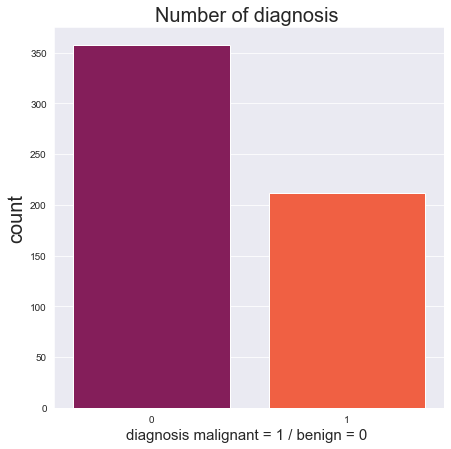

In [447]:
#bar chart
plt.rcParams['figure.figsize'] = 7, 7
sns.set_style("darkgrid")
ax = sns.countplot(x=data.diagnosis, palette="rocket", saturation=1.5)
plt.xlabel("diagnosis malignant = 1 / benign = 0 ", fontsize=15)
plt.ylabel("count", fontsize=20)
plt.title('Number of diagnosis ', fontsize=20)

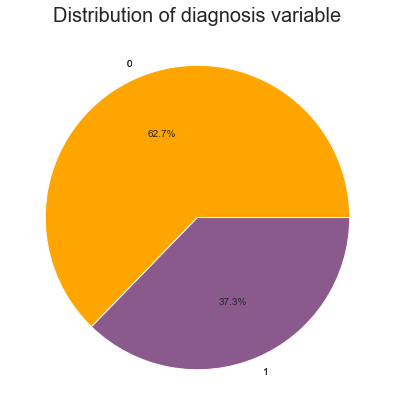

In [448]:
#pie chart in percentile
# B = benign => 0
# M = malignant => 1
label = data.diagnosis.value_counts().index
count = data.diagnosis.value_counts().values
color = ['orange', '#8B5A8C']

plt.pie(count, labels=label)
plt.title('Distribution of diagnosis variable', fontsize=20)
plt.figure(1, figsize=(20, 15))
plt.pie(count, labels=label, colors=color, autopct='%1.1f%%')
plt.show()

Ploting the histogram of these values so we can better observer their values and data distribution. In order to do so, we are going to separate, for each histogram, the values depending on the diagnosis column.

## 5.2 Features vs Diagnosis

Observations:
- mean values of cell radius, perimeter, area, compactness, concavity and concave points can be used in classification of the cancer. Larger values of these parameters tends to show a correlation with malignant tumors.
- mean values of texture, smoothness, symmetry or fractual dimension does not show a particular preference of one diagnosis over the other. In any of the histograms there are no noticeable large outliers that warrants further cleanup.

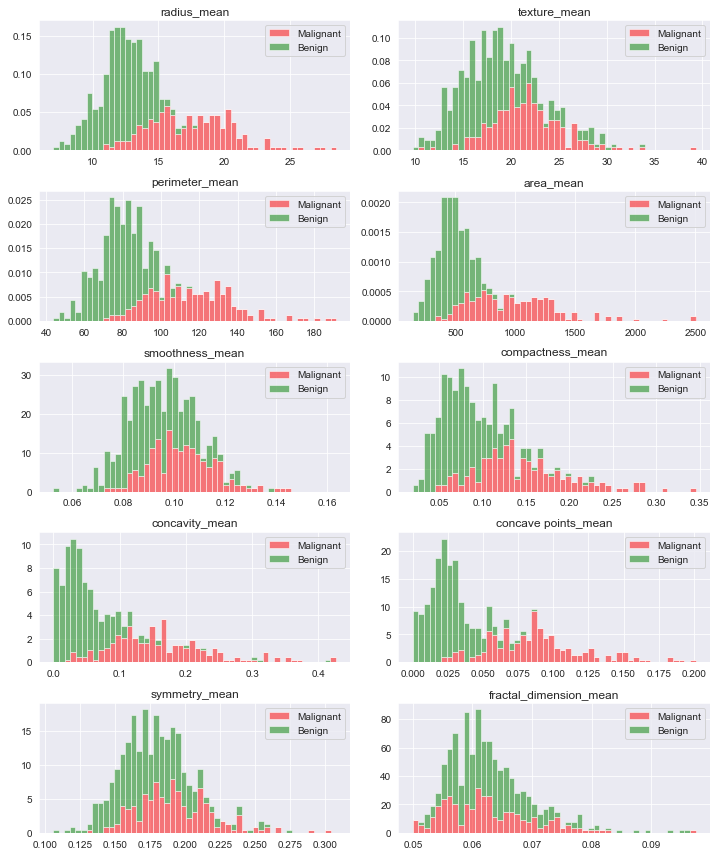

In [449]:
# B = benign => 0
# M = malignant => 1

features_mean = list(data.columns[1:11])
# split dataframe into two based on diagnosis
dfM = data[data['diagnosis'] == 1]
dfB = data[data['diagnosis'] == 0]

#Stack the data
plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 12))
axes = axes.ravel()
for idx, ax in enumerate(axes):
    ax.figure
    binwidth = (max(data[features_mean[idx]]) - min(data[features_mean[idx]])) / 50
    ax.hist([dfM[features_mean[idx]], dfB[features_mean[idx]]],
            bins=np.arange(min(data[features_mean[idx]]), max(data[features_mean[idx]]) + binwidth, binwidth),
            alpha=0.5, stacked=True, density=True, label=['Malignant', 'Benign'], color=['r', 'g'])
    ax.legend(loc='upper right')
    ax.set_title(features_mean[idx])
plt.tight_layout()
plt.show()

From these ten graphs we can observe, these features might be useful in predicting whether a patient has cancer or not due to the distinct grouping between malignant and benign. We can also see the most frequent malignant value of these features under each graph, although visually they may vary since we might not have an optimal bin width, bust most of them match with the values histograms show.

# 6 Feature Selection

[0.06570355 0.02422463 0.08252783 0.05170824 0.01023359 0.02650676
 0.05297484 0.07539389 0.00614222 0.00695365 0.02051316 0.00490609
 0.01458988 0.02853121 0.00661334 0.00702741 0.00789869 0.00992836
 0.00518749 0.00643257 0.07922871 0.02663948 0.07187652 0.08457554
 0.02014716 0.03532266 0.03942182 0.10149382 0.01585141 0.01144549]


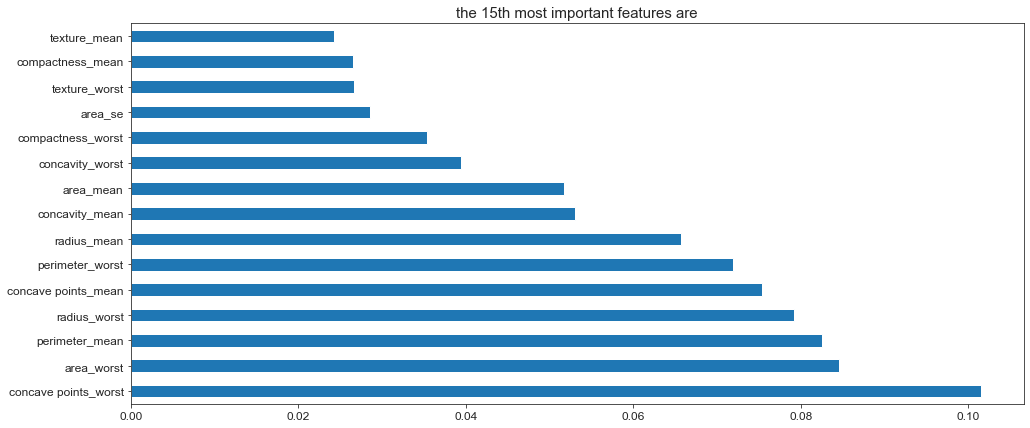

In [450]:
# B = benign => 0
# M = malignant => 1

plt.rcParams['figure.figsize'] = 16, 7
sns.set_style("ticks")

x = data.drop('diagnosis', axis=1)
y = data.diagnosis

model = ExtraTreesClassifier()
model.fit(x, y)

print(model.feature_importances_)
feat_importance = pd.Series(model.feature_importances_, index=x.columns)

feat_importance.nlargest(15).plot(kind='barh', fontsize=12)
plt.title('the 15th most important features are', fontsize=15)
plt.show()

Let's check our current column name.

In [451]:
data.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

Drop out unimportant features, and choose just the best 15 according the bar chart.

In [452]:
data = data.drop(
    ['texture_mean', 'smoothness_mean', 'compactness_mean', 'symmetry_mean', 'perimeter_se', 'compactness_se',
     'concavity_se', 'concave points_se', 'smoothness_worst', 'symmetry_worst', 'fractal_dimension_worst',
     'fractal_dimension_mean', 'texture_se', 'smoothness_se', 'symmetry_se', 'fractal_dimension_se'], axis=1)

In [453]:
# Split first into training and test datasets
X = data.drop('diagnosis', axis=1)
y = data.diagnosis

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

In [454]:
# Split again into validation and true holdout (test) datasets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,
                                                random_state=1,
                                                stratify=y_test)

In [455]:
# Examine shapes of the subsets
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(455, 14) (455,)
(57, 14) (57,)
(57, 14) (57,)


## 6.2 Resampling

The preprocessing step is to deal with the class imbalance. As we can see earlier Benign: 0 is more than 60% pf the data set while Malignant:1 is only 30%
The overall strategy is to under-sample the bigger classes and over-sample the smaller ones so that both classes are the same size as the median-sized class.

First, Let's put the training data back into one DataFrame to make things a little easier.

In [457]:
# Concatenate X_train and y_train for resampling
df_train = pd.concat([X_train, y_train], axis=1)
print(len(df_train))
df_train.head()

455


,radius_mean,perimeter_mean,area_mean,concavity_mean,concave points_mean,radius_se,area_se,radius_worst,texture_worst,perimeter_worst,area_worst,compactness_worst,concavity_worst,concave points_worst,diagnosis
195,12.91,82.53,516.4,0.03873,0.02377,0.1942,15.750,13.88,22.00,90.81,600.6,0.1506,0.1764,0.08235,0
560,14.05,91.38,600.4,0.04462,0.04304,0.3645,29.840,15.30,33.17,100.20,706.7,0.2264,0.1326,0.10480,0
544,13.87,89.77,584.8,0.03688,0.02369,0.2720,23.120,15.05,24.75,99.17,688.6,0.2037,0.1377,0.06845,0
495,14.87,96.12,680.9,0.06824,0.04951,0.2323,21.840,16.01,28.48,103.90,783.6,0.1388,0.1700,0.10170,0
527,12.34,78.94,468.5,0.02958,0.02647,0.1166,8.955,13.61,19.27,87.22,564.9,0.2074,0.1791,0.10700,0


In [ ]:
# Concatenate X_train and y_train for resampling
df_train = pd.concat([X_train, y_train], axis=1)
print(len(df_train))
df_train.head()

In [ ]:
# Class count
count_class_0, count_class_1 = df_train['diagnosis'].value_counts()

# Divide by class
df_class_0 = df_train[df_train['diagnosis'] == 0]
df_class_1 = df_train[df_train['diagnosis'] == 1]

print(count_class_0)
print(count_class_1)

In [ ]:
# Balance samples - making sure that we have the same number of samples for all possible results
sample_size = min(count_class_0, count_class_1,)

df_class_0_under = df_class_0.sample(sample_size, random_state=42)
df_class_1_under = df_class_1.sample(sample_size, random_state=42)

# Concat all samples into a single dataframe and re-sample the whole dataset to re-introduce order randomness of the rows
df_balanced = pd.concat([df_class_0_under, df_class_1_under]).sample(frac=1, random_state=42)

print('Balanced sampling:')
print(df_balanced['diagnosis'].value_counts())

df_balanced['diagnosis'].value_counts().plot(kind='bar', title='Count (target)');

The final count above shows that the classes are now balanced. Creating train test split data for resampled data will be shown and test with the models in section 7.

In [ ]:
trainset, testset = train_test_split(df_balanced, test_size=0.2, random_state=42)
print(trainset['diagnosis'].value_counts())
print(testset['diagnosis'].value_counts())

In [ ]:
X_train_resampled = trainset.drop(['diagnosis'], axis=1)
y_train_resampled = trainset['diagnosis']
X_test_resampled = testset.drop(['diagnosis'], axis=1)
y_test_resampled = testset['diagnosis']

## 6.3 Scaling

The next transformation is to standardize the features.

In [461]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_resampled)
X_scaled = pd.DataFrame(X_scaled)

In [462]:
# Check the results
X_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,3.400000e+02,3.400000e+02,3.400000e+02,3.400000e+02,3.400000e+02,3.400000e+02,3.400000e+02,3.400000e+02,3.400000e+02,3.400000e+02,3.400000e+02,3.400000e+02,340.000000,3.400000e+02
mean,1.671865e-16,-2.089832e-16,3.343731e-16,4.179663e-17,-1.671865e-16,-1.671865e-16,-1.671865e-16,1.671865e-16,-7.523394e-16,6.687461e-16,1.253899e-16,4.179663e-17,0.000000,2.507798e-16
std,1.001474e+00,1.001474e+00,1.001474e+00,1.001474e+00,1.001474e+00,1.001474e+00,1.001474e+00,1.001474e+00,1.001474e+00,1.001474e+00,1.001474e+00,1.001474e+00,1.001474,1.001474e+00
min,-2.105653e+00,-2.058070e+00,-1.531661e+00,-1.219892e+00,-1.364336e+00,-1.131877e+00,-8.342892e-01,-1.795846e+00,-2.156398e+00,-1.758942e+00,-1.290713e+00,-1.388356e+00,-1.378651,-1.845322e+00
25%,-7.317808e-01,-7.396325e-01,-7.247112e-01,-7.994030e-01,-8.112024e-01,-6.881865e-01,-5.923597e-01,-7.558534e-01,-7.463687e-01,-7.918375e-01,-7.164998e-01,-7.261254e-01,-0.772652,-8.244592e-01
50%,-1.976548e-01,-1.803810e-01,-2.977927e-01,-2.723864e-01,-2.724760e-01,-3.216896e-01,-3.828120e-01,-2.021539e-01,-2.857914e-02,-2.147187e-01,-2.980435e-01,-2.609313e-01,-0.136887,-1.004898e-01
75%,6.592426e-01,6.445077e-01,5.623804e-01,6.278587e-01,7.179306e-01,3.752171e-01,2.620865e-01,6.245436e-01,7.091712e-01,6.092442e-01,4.904150e-01,5.284055e-01,0.564913,7.758660e-01
max,3.414955e+00,3.522162e+00,4.757733e+00,3.799257e+00,3.229306e+00,7.288812e+00,1.064360e+01,3.617892e+00,3.699296e+00,3.778916e+00,5.215889e+00,4.495674e+00,4.142262,2.323366e+00


The features have now been standardized so that they all have a mean of 0 and a standard deviation of 1.

Let's just get a quick visual confirmation of this change with some histograms.

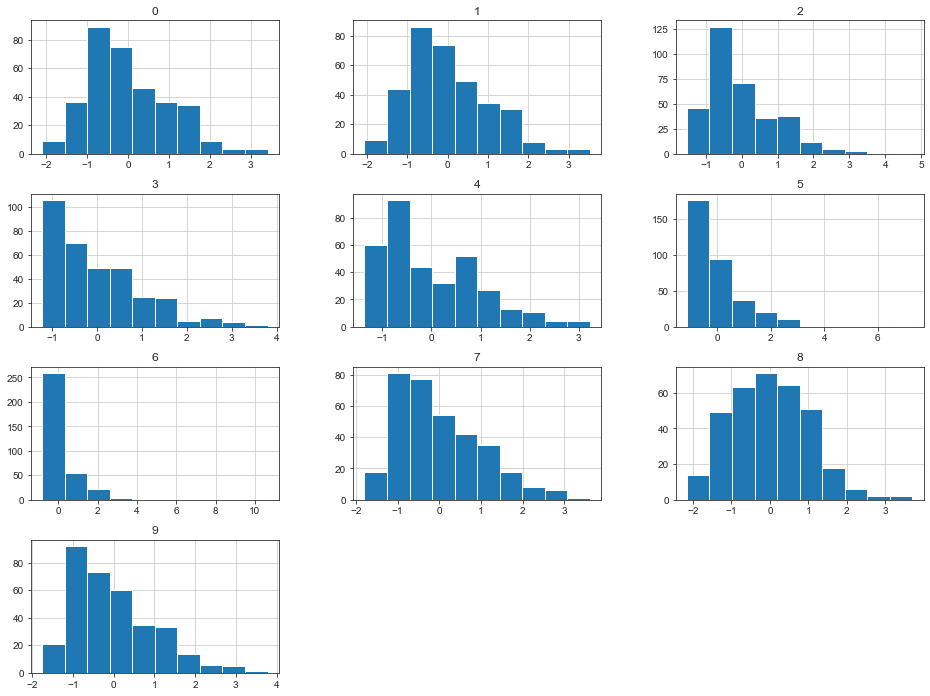

In [463]:
# Visualize the distributions again
X_scaled.loc[:, :9].hist(figsize=(16, 12));

## 6.4 PCA

Principal Components Analysis takes the features we have and tries to combine them in ways that maximize the amount of variance the components can explain in the data.
PCA can help us avoid the negative effects of having numerous features while still allowing us to account for as much variance as possible.

We aim to find a number of components that will explain at least 80% of the variance in the data.
First, let's see how much variance we can explain with a wide range of components.

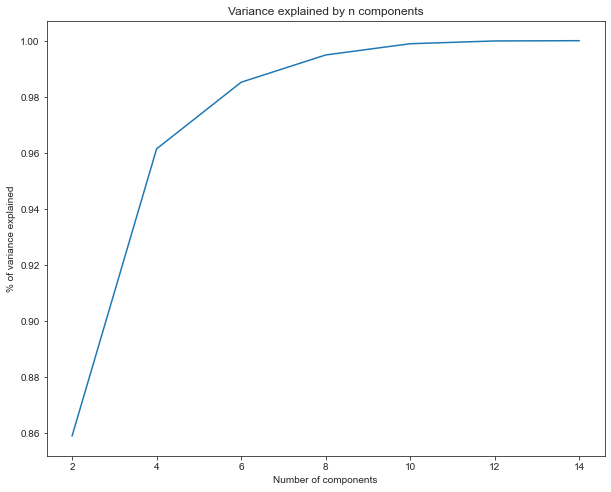

In [464]:
from sklearn.decomposition import PCA

# Try several numbers of components to explain 80% of variance
comps = [2, 4, 6, 8, 10, 12, 14]
var_sums = []
for comp in comps:
    pca = PCA(n_components=comp)
    pca.fit_transform(X_scaled)
    var_sums.append(np.sum(pca.explained_variance_ratio_))

# Visualize results
plt.figure(figsize=(10, 8))
plt.plot(comps, var_sums)
plt.xlabel('Number of components')
plt.ylabel('% of variance explained')
plt.title('Variance explained by n components')
plt.xticks([2, 4, 6, 8, 10, 12, 14])
plt.show();

Fourteenth components seem to capture about 99% of the variance in the data, which aligns with what we expected based on the feature importance plot above.

# 7. Machine Learning Applications

We will take 80% of the total dataset to use as training data. The remaining 20% of the original dataset will be devoted half of that to a true holdout set, which will be used to evaluate the final versions of each of my models.

# 7.1 Bases Models

In [ ]:
# Def X and Y
X = data.drop('diagnosis', axis=1)
y = data.diagnosis

In [ ]:
# Normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Train_test split for base model
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [477]:
models = {
    "Logistic Regression": LogisticRegression(),
    "KNeighbors": KNeighborsClassifier(),
    "Decision Tre": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGB Classifier": XGBClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Light GBM Classifier": LGBMClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier(),
    "CatBoost Classifier": CatBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "Support Vector Classifier": SVC()
}

base_models_accuracy_score = {}

In [478]:
for name, model in models.items():
    print()
    print('=====================================')
    print(f'Training Model {name}')
    print('=====================================')
    print()

    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    print_metrics(y_train, y_test, y_pred_test, y_pred_train)
    plot_metrics(model, X_train, y_train)
    plot_roc()

    base_models_accuracy_score[name] = accuracy_score(y_test, y_pred_test)

Training Model Logistic Regression 

Accuracy: 0.9736842105263158
Classification Report : 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Testing Confusion Matrix: 
[[70  1]
 [ 2 41]]
The Recall score: 0.9534883720930233
The Precision score: 0.9761904761904762
The F-1 score: 0.9647058823529412

Training Model KNeighbors 

Accuracy: 0.9649122807017544
Classification Report : 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        71
           1       0.95      0.95      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114

Testing Confusi

## 7.2 Transformed Resample data for Models

In [ ]:
trainset, testset = train_test_split(df_balanced, test_size=0.2, random_state=42)

In [ ]:
X_train_resampled = trainset.drop(['diagnosis'], axis=1)
y_train_resampled = trainset['diagnosis']
X_test_resampled = testset.drop(['diagnosis'], axis=1)
y_test_resampled = testset['diagnosis']

In [479]:
models_resampled = {
    "Logistic Regression": LogisticRegression(),
    "KNeighbors": KNeighborsClassifier(),
    "Decision Tre": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGB Classifier": XGBClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Light GBM Classifier": LGBMClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier(),
    "CatBoost Classifier": CatBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "Support Vector Classifier": SVC()
}

models_resampled_accuracy_score = {}

In [480]:
for name, model in models_resampled.items():
    print()
    print('=====================================')
    print(f'Training Model {name}')
    print('=====================================')
    print()

    model.fit(X_train_resampled, y_train_resampled)
    y_pred_test = model.predict(X_test_resampled)
    y_pred_train = model.predict(X_train_resampled)


    print_metrics(y_train_resampled, y_test_resampled, y_pred_test, y_pred_train)
    plot_metrics(model, X_train_resampled, y_train_resampled)
    plot_roc()

    models_resampled_accuracy_score[name] = accuracy_score(y_test_resampled, y_pred_test)

Training Model Logistic Regression 

Accuracy: 0.9794117647058823
Classification Report : 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       170
           1       0.99      0.97      0.98       170

    accuracy                           0.98       340
   macro avg       0.98      0.98      0.98       340
weighted avg       0.98      0.98      0.98       340

Testing Confusion Matrix: 
[[168   2]
 [  5 165]]
The Recall score: 0.9705882352941176
The Precision score: 0.9880239520958084
The F-1 score: 0.9792284866468843

Training Model KNeighbors 

Accuracy: 0.9794117647058823
Classification Report : 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       170
           1       0.99      0.97      0.98       170

    accuracy                           0.98       340
   macro avg       0.98      0.98      0.98       340
weighted avg       0.98      0.98      0.98       340

Testing Con

## 7.3 Applied Pipline Data for models

Pipeline is used here so that it can easily transform validation and test sets in the same way as training set without leaking data from one set to another.

In [ ]:
# Build a pipeline for the preprocessing steps
pipe_prepro = Pipeline([('scaler', StandardScaler()),
                        ('pca', PCA(n_components=13))])

Fit the preprocessing pipeline to the training data which has been resampled, then use the pipeline to transform the validation and test sets separately.

In [ ]:
#Fit the pipeline and transform the training dataset
X_train_trans = pipe_prepro.fit_transform(X_train_resampled)
y_train_trans = pipe_prepro.fit_transform(y_train_resampled)
# Use the pipeline to transform the validation and test datasets
X_test_trans = pipe_prepro.transform(X_test_resampled)
y_test_trans = pipe_prepro.transform(y_test_resampled)

In [481]:
models_pipeline = {
    "Logistic Regression": LogisticRegression(),
    "KNeighbors": KNeighborsClassifier(),
    "Decision Tre": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGB Classifier": XGBClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Light GBM Classifier": LGBMClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier(),
    "CatBoost Classifier": CatBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "Support Vector Classifier": SVC()
}

models_pipeline_accuracy_score = {}

preprocessor = make_pipeline(MinMaxScaler())


In [482]:
for name, model in models_pipeline.items():
    print()
    print('=====================================')
    print(f'Training Model {name}')
    print('=====================================')
    print()

    model_pipeline = make_pipeline(preprocessor, model)

    model_pipeline.fit(X_train_trans, y_train_trans)
    y_pred_test_trans = model_pipeline.predict(X_test_trans)
    y_pred_train_trans = model_pipeline.predict(X_train_trans)

    print_metrics(y_train_trans, y_test_trans, y_pred_test_trans, y_pred_train_trans)
    plot_metrics(model, X_train_resampled, y_train_resampled)
    plot_roc()

    models_pipeline_accuracy_score[name] = accuracy_score(y_test_resampled, y_pred_test_trans)

(Using Pipeline) Training Model Logistic Regression 

Accuracy: 0.9649122807017544
Classification Report : 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

Testing Confusion Matrix: 
[[70  1]
 [ 3 40]]
The Recall score: 0.9302325581395349
The Precision score: 0.975609756097561
The F-1 score: 0.9523809523809524

(Using Pipeline) Training Model KNeighbors 

Accuracy: 0.9736842105263158
Classification Report : 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97    

# 8. Hyperparameter Tuning on Different Models

## 8.1 Optimized Support Vector Machines using GridSearchCV



In [483]:
# Find best hyperparameters
model_svm = SVC(random_state=random_state)
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'poly', 'sigmoid']}

CV_model_svm = GridSearchCV(estimator=model_svm, param_grid=param_grid, scoring='accuracy', verbose=1, n_jobs=-1,
                            error_score='raise', refit=True)
CV_model_svm.fit(X_train, y_train)

best_parameters = CV_model_svm.best_params_
print('The best parameters for using Support Vector Machines model is', best_parameters)
print('The best score for using Support Vector Machines  model is', CV_model_svm.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
The best parameters for using Support Vector Machines model is {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
The best score for using Support Vector Machines  model is 0.9714285714285715


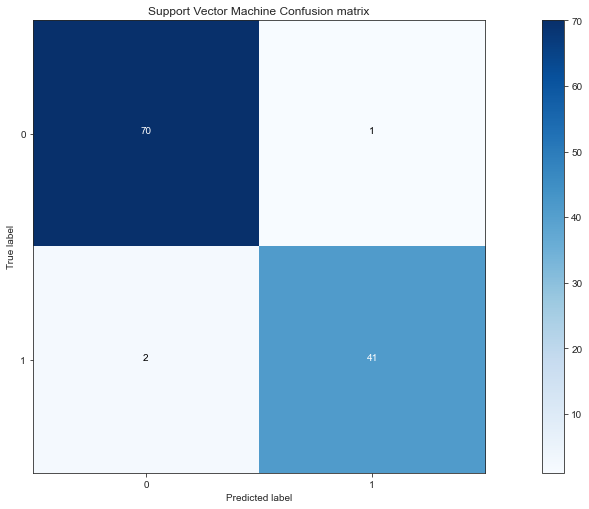

Accuracy  =     0.974
Misclassification =     74.049
Precision =     0.976
Recall    =     0.953
F1_score  =     0.965


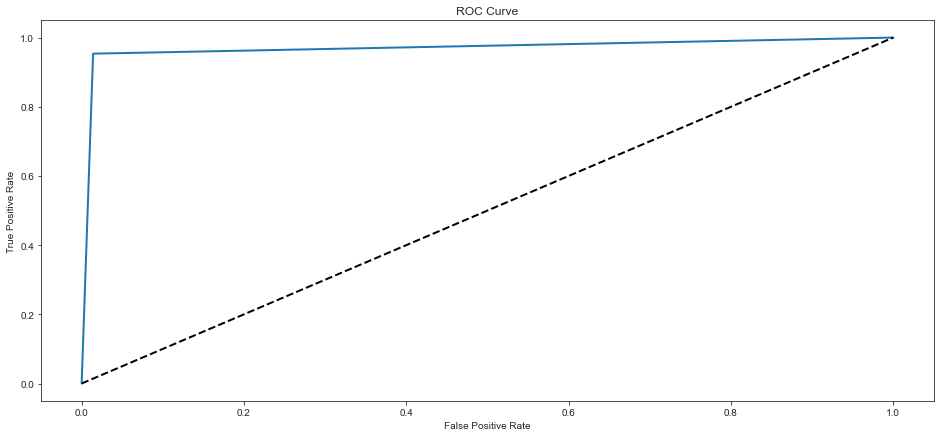

In [484]:
#Log with best hyperparameters
CV_model_svm = SVC(C=100.0, gamma=0.01, kernel='rbf')


CV_model_svm.fit(X_train, y_train)
y_pred_test = CV_model_svm.predict(X_test)
y_pred_train = CV_model_svm.predict(X_train)
y_score = CV_model_svm.decision_function(X_test)

# Save accuracy score for summary display in section 8
acc_svm = metrics.accuracy_score(y_test, y_pred_test)

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred_test)
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cm,
                      classes=class_names,
                      title='Support Vector Machine Confusion matrix')
plt.savefig('6')
plt.show()

print_metrics(y_train, y_test, y_pred_test, y_pred_train)

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_pred_test)
plot_roc()
print(y_score)

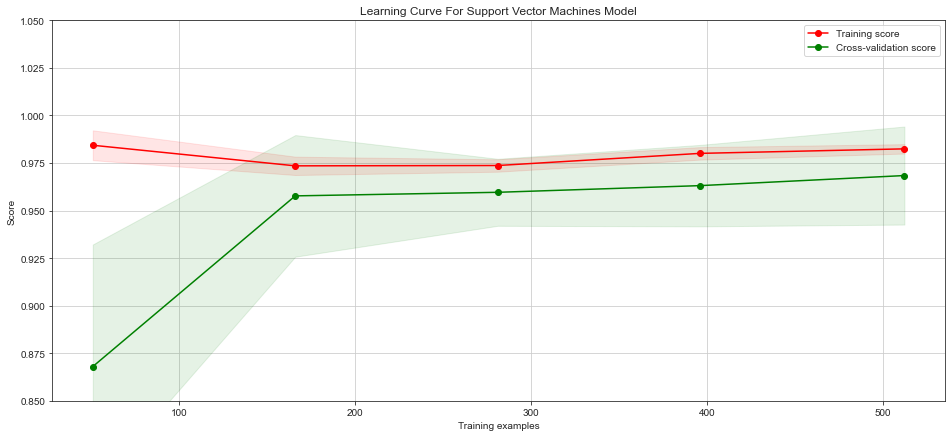

In [485]:
#Learning curve Log with best hyperparameters
plot_learning_curve(CV_model_svm, 'Learning Curve For Support Vector Machines Model', X, y, (0.85, 1.05), 10)
plt.savefig('7')
plt.show()

In [486]:
# Cross val Log
cross_log = cross_val_metrics(CV_model_svm)

[accuracy] : 0.96841 (+/- 0.01423)
[precision] : 0.96234 (+/- 0.02368)
[recall] : 0.95293 (+/- 0.01454)


In [487]:
# Pickle the model for later used
with open('svm.pickle', 'wb') as f:
    pickle.dump(CV_model_svm, f, pickle.HIGHEST_PROTOCOL)

## 8.2 Optimized KNN using GridSearchCV

In [488]:
# Find best hyperparameters
k_range = list(range(1, 31))
weight_options = ["uniform", "distance"]

model_knn = KNeighborsClassifier()
param_grid = dict(n_neighbors=k_range, weights=weight_options)

CV_model_knn = GridSearchCV(estimator=model_knn, param_grid=param_grid, return_train_score=False, verbose=1, n_jobs=-1,
                            error_score='raise')
CV_model_knn.fit(X_train, y_train)

best_parameters = CV_model_knn.best_params_
print('The best parameters for using KNN model is: ', best_parameters)
print('The best score for using KNN model is: ', CV_model_knn.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
The best parameters for using KNN model is:  {'n_neighbors': 3, 'weights': 'uniform'}
The best score for using KNN model is:  0.9648351648351647


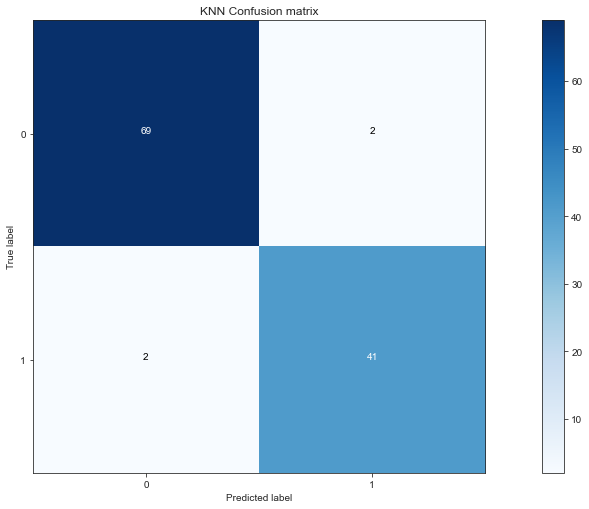

Accuracy  =     0.965
Misclassification =     75.049
Precision =     0.953
Recall    =     0.953
F1_score  =     0.953


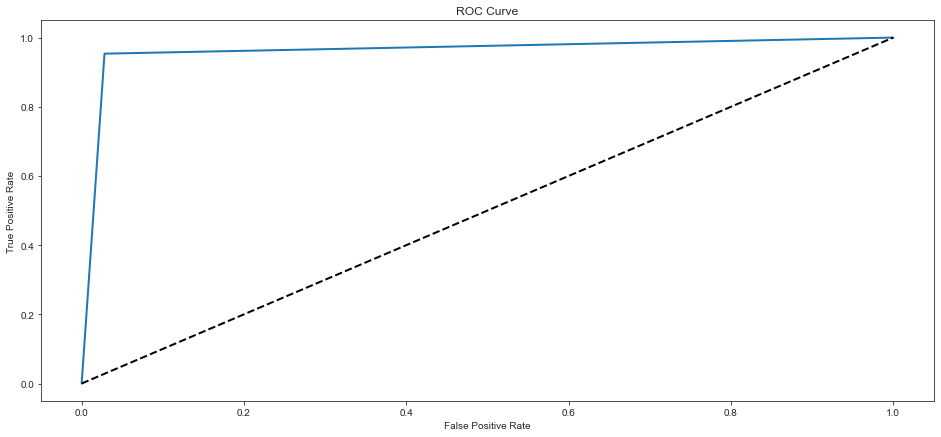

In [489]:
#Log with best hyperparameters
CV_model_knn = KNeighborsClassifier(n_neighbors=4, weights='uniform')

CV_model_knn.fit(X_train, y_train)
y_pred = CV_model_knn.predict(X_test)
y_score = CV_model_knn.score(X_test, y_test)

# Save accuracy score for summary display in section 9
acc_knn = metrics.accuracy_score(y_test, y_pred)

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cm,
                      classes=class_names,
                      title='KNN Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_pred)
plot_roc()

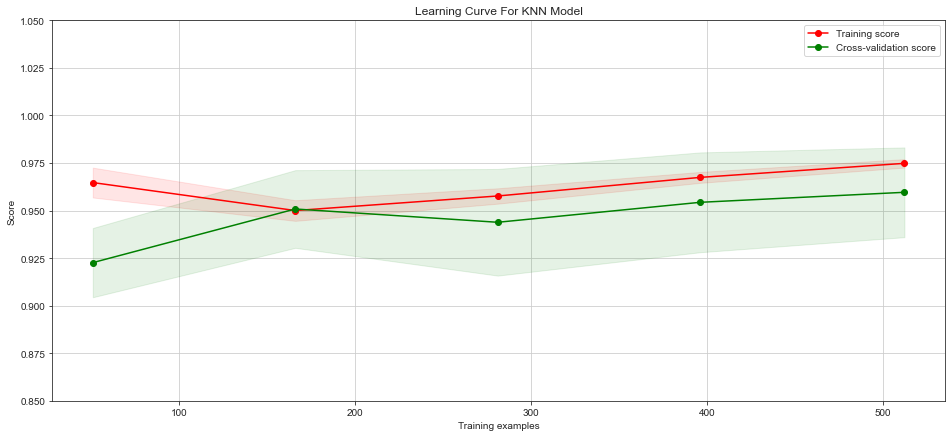

In [490]:
#Learning curve Log with best hyperparameters
plot_learning_curve(CV_model_knn, 'Learning Curve For KNN Model', X, y, (0.85, 1.05), 10)
plt.savefig('7')
plt.show()

In [491]:
# Cross val Log
cross_log = cross_val_metrics(CV_model_knn)

[accuracy] : 0.96311 (+/- 0.01285)
[precision] : 0.97987 (+/- 0.01008)
[recall] : 0.92004 (+/- 0.02762)


In [492]:
# Pickle the model for later used
with open('knn.pickle', 'wb') as f:
    pickle.dump(CV_model_knn, f, pickle.HIGHEST_PROTOCOL)

## 8.3 Optimized Logistic Regression using GridSearchCV

In [493]:
# Find best hyperparameters
model_lr = LogisticRegression(random_state=random_state)
param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

CV_model_lr = GridSearchCV(estimator=model_lr, param_grid=param_grid, scoring='accuracy', verbose=1, n_jobs=-1,
                           error_score='raise')
CV_model_lr.fit(X_train, y_train)

best_parameters = CV_model_lr.best_params_
print('The best parameters for using Logistic Regression model is: ', best_parameters)
print('The best score for using Logistic Regression model is: ', CV_model_lr.best_score_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
The best parameters for using Logistic Regression model is:  {'C': 1, 'penalty': 'l2'}
The best score for using Logistic Regression model is:  0.9692307692307691


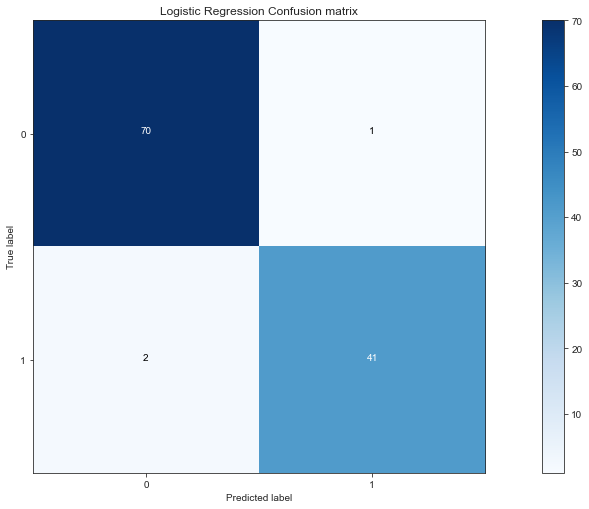

Accuracy  =     0.974
Misclassification =     74.049
Precision =     0.976
Recall    =     0.953
F1_score  =     0.965


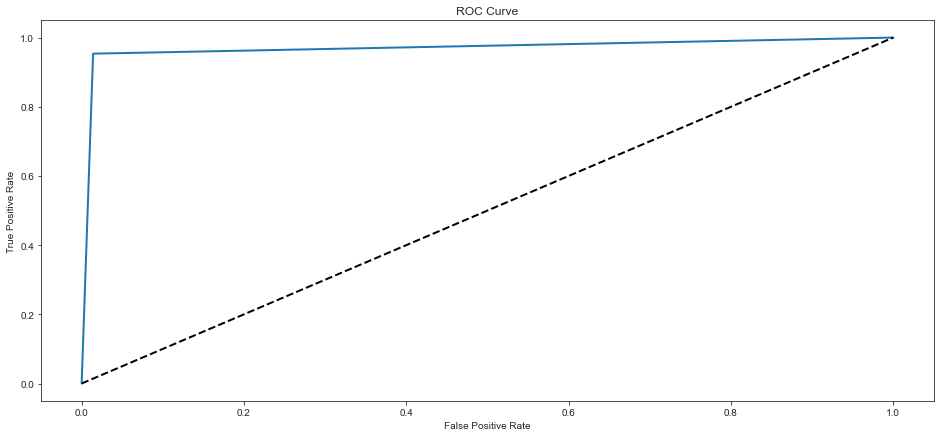

In [494]:
#Log with best hyperparameters
CV_model_lr = LogisticRegression(C=1,penalty='l2', random_state=random_state)

CV_model_lr.fit(X_train, y_train)
y_pred = CV_model_lr.predict(X_test)
y_score = CV_model_lr.decision_function(X_test)

# Save accuracy score for summary display in section 9
acc_logreg = metrics.accuracy_score(y_test, y_pred)

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cm,
                      classes=class_names,
                      title='Logistic Regression Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_pred)
plot_roc()

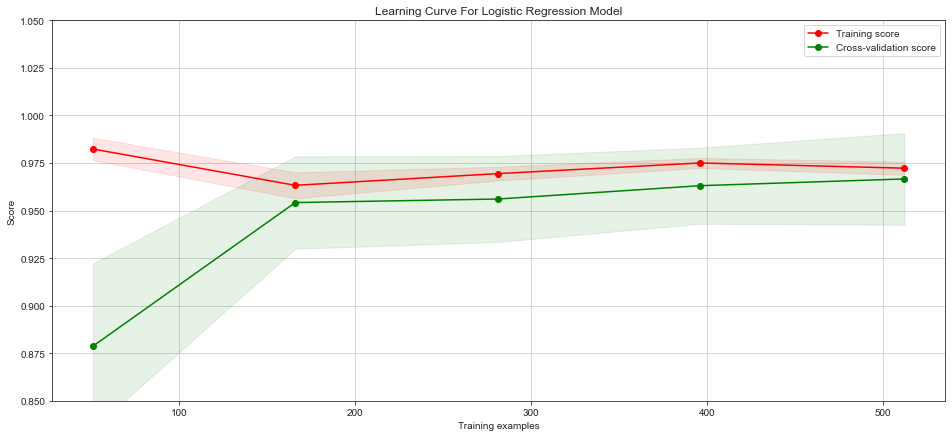

In [495]:
#Learning curve Log with best hyperparameters
plot_learning_curve(CV_model_lr, 'Learning Curve For Logistic Regression Model', X, y, (0.85, 1.05), 10)
plt.savefig('7')
plt.show()

In [496]:
# Cross val Log
cross_log = cross_val_metrics(CV_model_lr)

[accuracy] : 0.96313 (+/- 0.01285)
[precision] : 0.95703 (+/- 0.01769)
[recall] : 0.94352 (+/- 0.01856)


In [497]:
# Pickle the model
with open('lr.pickle', 'wb') as f:
    pickle.dump(CV_model_lr, f, pickle.HIGHEST_PROTOCOL)

## 8.4 Optimized Random Forest using GridsearchCV

In [498]:
# Find best hyperparameters
model_rf = RandomForestClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [200, 500],
    'max_features': ['log2'],
    'max_depth': [4, 5, 6, 7, 8],
    'criterion': ['gini', 'entropy']
}

CV_model_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid, scoring='accuracy',
                           verbose=1, n_jobs=-1, error_score='raise', cv=5)
CV_model_rf.fit(X_train, y_train)

best_parameters = CV_model_rf.best_params_
print('The best parameters for using Random Forest is: ', best_parameters)
print('The best score for using Random Forest is: ', CV_model_rf.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
The best parameters for using Random Forest is:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 200}
The best score for using Random Forest is:  0.9626373626373625


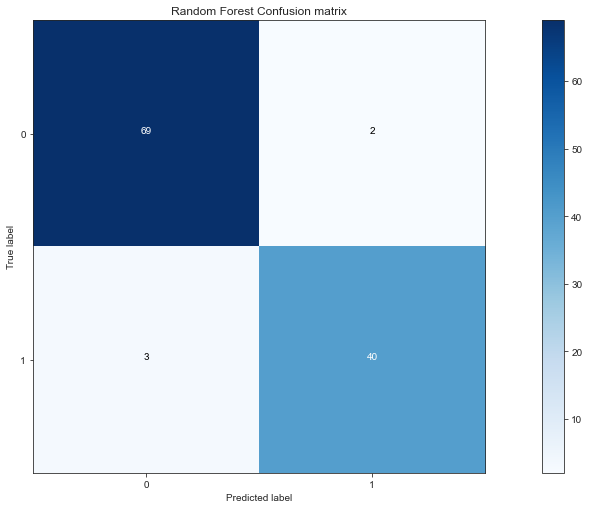

Accuracy  =     0.956
Misclassification =     76.075
Precision =     0.952
Recall    =     0.930
F1_score  =     0.941


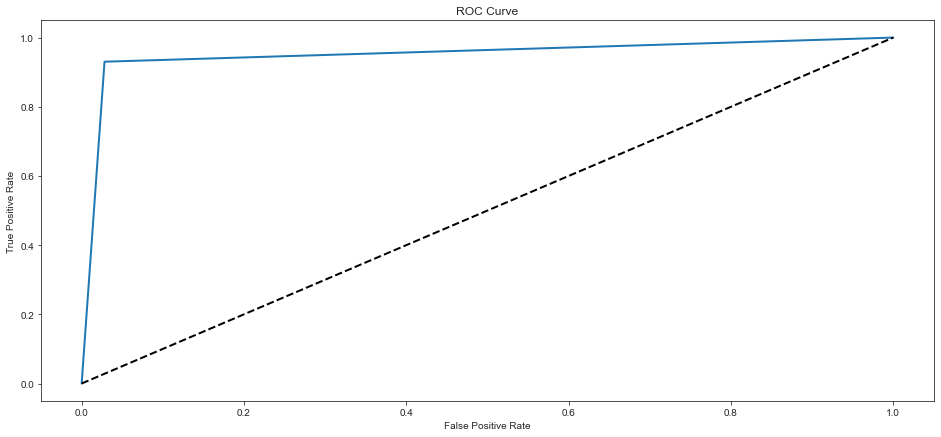

In [499]:
#Log with best hyperparameters
CV_model_rf = RandomForestClassifier(criterion='gini', max_depth=7, max_features='log2', n_estimators=200)

CV_model_rf.fit(X_train, y_train)
y_pred = CV_model_rf.predict(X_test)
#y_score = CV_model_rf.decision_function(X_test)

# Save accuracy score for summary display in section 9
acc_randomforest = metrics.accuracy_score(y_test, y_pred)

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cm,
                      classes=class_names,
                      title='Random Forest Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_pred)
plot_roc()

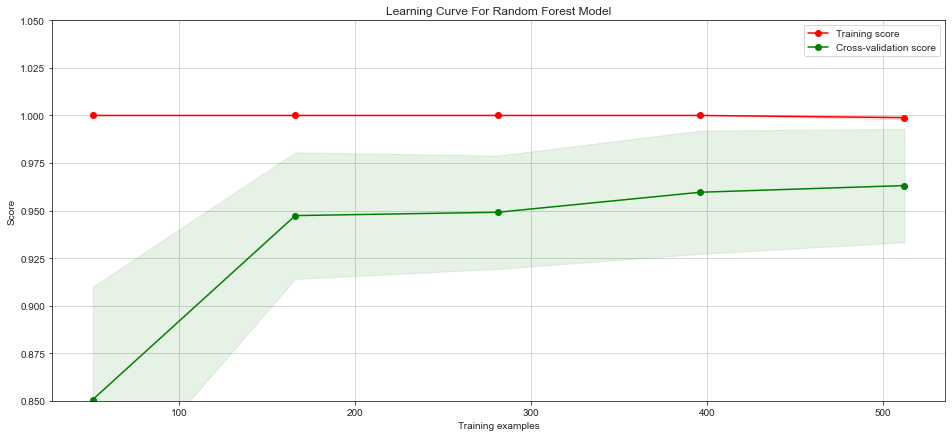

In [500]:
#Learning curve Log with best hyperparameters
plot_learning_curve(CV_model_rf, 'Learning Curve For Random Forest Model', X, y, (0.85, 1.05), 10)
plt.savefig('7')
plt.show()

In [501]:
# Cross val Log
cross_log = cross_val_metrics(CV_model_rf)

[accuracy] : 0.95785 (+/- 0.02564)
[precision] : 0.96630 (+/- 0.03220)
[recall] : 0.93444 (+/- 0.04232)


In [502]:
# Pickle the model for later used
with open('rf.pickle', 'wb') as f:
    pickle.dump(CV_model_rf, f, pickle.HIGHEST_PROTOCOL)

## 8.5 Optimized Decision Tree using GridSearchCV

In [503]:
# Find best hyperparameters
model_dt = DecisionTreeClassifier()
param_grid = {'max_features': ['sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth': [5, 6, 7, 8, 9],
              'criterion': ['gini', 'entropy']
              }

CV_model_dt = GridSearchCV(estimator=model_dt, param_grid=param_grid, scoring='accuracy', verbose=1, n_jobs=-1,
                           error_score='raise', cv=5)
CV_model_dt.fit(X_train, y_train)

best_parameters = CV_model_dt.best_params_
print('The best parameters for using Decision Tree model is: ', best_parameters)
print('The best score for using Decision Tree model is: ', CV_model_dt.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
The best parameters for using Decision Tree model is:  {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 'sqrt'}
The best score for using Decision Tree model is:  0.9472527472527472


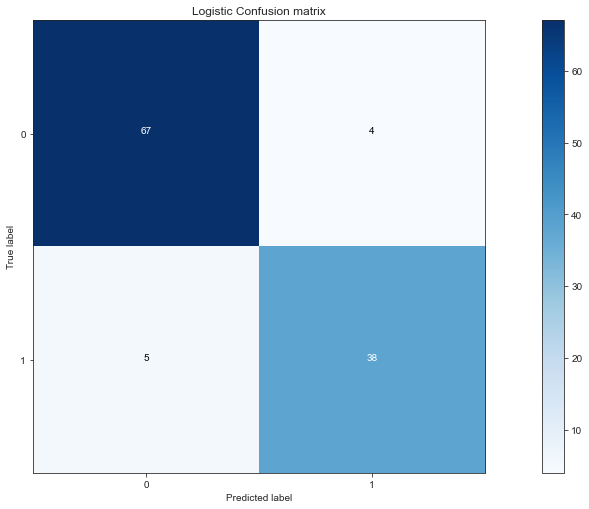

Accuracy  =     0.921
Misclassification =     80.132
Precision =     0.905
Recall    =     0.884
F1_score  =     0.894


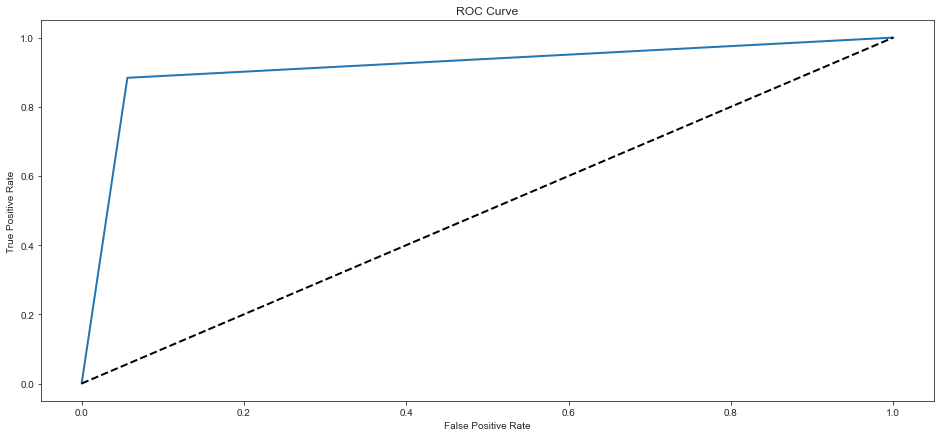

In [504]:
#Log with best hyperparameters
CV_model_dt = DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=9, max_features='sqrt')

CV_model_dt.fit(X_train, y_train)
y_pred = CV_model_dt.predict(X_test)
#y_score = CV_model_dt.decision_function(X_test)

# Save accuracy score for summary display in section 9
acc_dt =  metrics.accuracy_score(y_test, y_pred)

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cm,
                      classes=class_names,
                      title='Logistic Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_pred)
plot_roc()

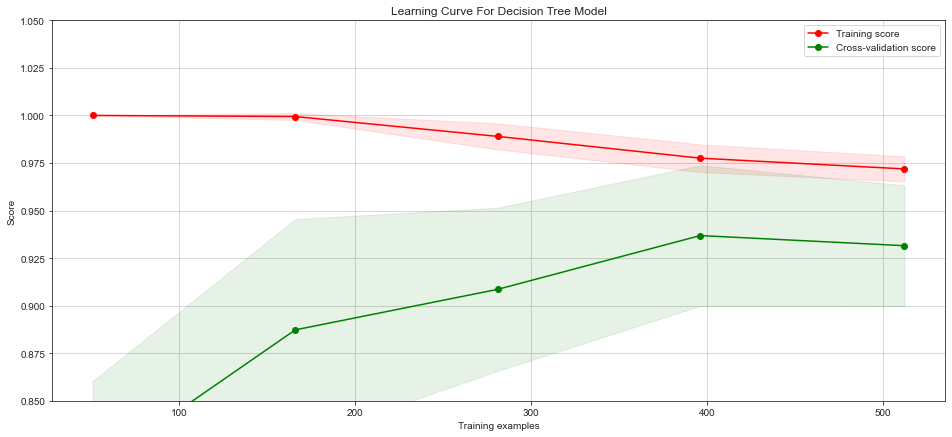

In [505]:
#Learning curve Log with best hyperparameters
plot_learning_curve(CV_model_dt, 'Learning Curve For Decision Tree Model', X, y, (0.85, 1.05), 10)
plt.savefig('7')
plt.show()

In [506]:
# Cross val Log
cross_log = cross_val_metrics(CV_model_dt)

[accuracy] : 0.94032 (+/- 0.03105)
[precision] : 0.90785 (+/- 0.05112)
[recall] : 0.92946 (+/- 0.03290)


In [507]:
# Pickle the model for later used
with open('dt.pickle', 'wb') as f:
    pickle.dump(CV_model_dt, f, pickle.HIGHEST_PROTOCOL)

## 8.6 Optimized GBM using GridSearchCV

In [508]:
# Find best hyperparameters
model_gbm = GradientBoostingClassifier(random_state=random_state)
param_grid = {
    "loss": ["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth": [3, 5, 8],
    "max_features": ["log2", "sqrt"],
    "criterion": ["friedman_mse", "squared_error"],
    "subsample": [0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators": [10]
}

CV_model_gbm = GridSearchCV(estimator=model_gbm, param_grid=param_grid, scoring='accuracy', verbose=1, n_jobs=-1,
                            error_score='raise', refit=False, cv=2)
CV_model_gbm.fit(X_train, y_train)

best_parameters = CV_model_gbm.best_params_
print('The best parameters for using GBM model is: ', best_parameters)
print('The best score for using GBM model is: ', CV_model_gbm.best_score_)

Fitting 2 folds for each of 84672 candidates, totalling 169344 fits
The best parameters for using GBM model is:  {'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 0.13636363636363638, 'min_samples_split': 0.1, 'n_estimators': 10, 'subsample': 1.0}
The best score for using GBM model is:  0.956034083004869


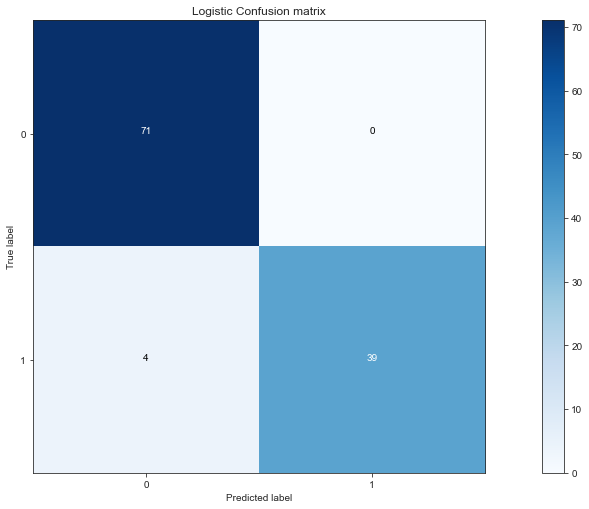

Accuracy  =     0.965
Misclassification =     75.103
Precision =     1.000
Recall    =     0.907
F1_score  =     0.951


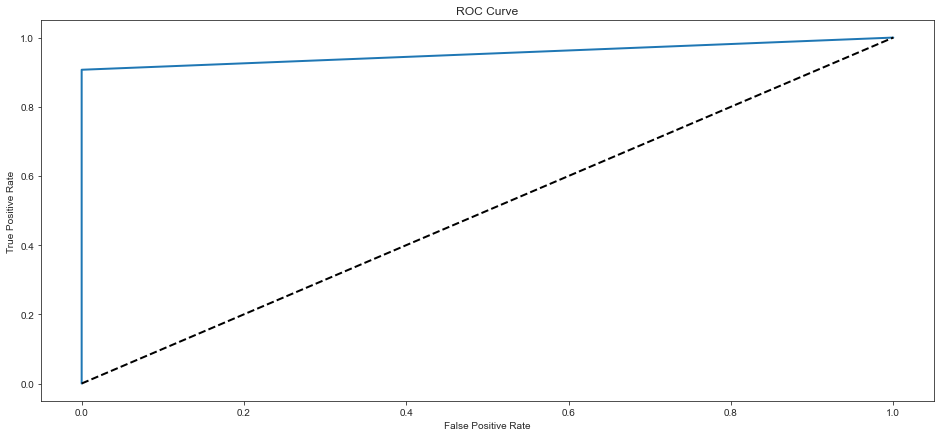

In [509]:
#Log with best hyperparameters
CV_model_gbm = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.2, loss='deviance', max_depth=3,
                                          max_features='log2', min_samples_leaf=0.136363636363638, min_samples_split=0.1,
                                          n_estimators=10, subsample=1.0)

CV_model_gbm.fit(X_train, y_train)
y_pred = CV_model_gbm.predict(X_test)
y_score = CV_model_gbm.decision_function(X_test)

# Save accuracy score for summary display in section 9
acc_gbm =  metrics.accuracy_score(y_test, y_pred)

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cm,
                      classes=class_names,
                      title='Logistic Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_pred)
plot_roc()

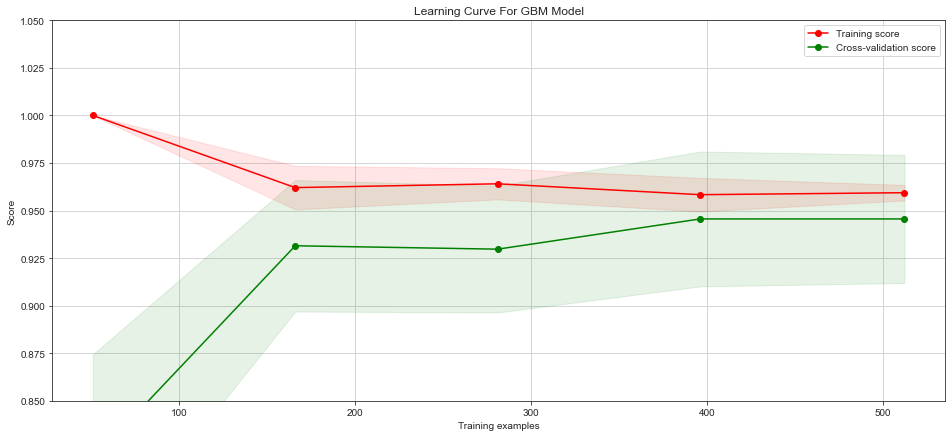

In [510]:
#Learning curve Log with best hyperparameters
plot_learning_curve(CV_model_gbm, 'Learning Curve For GBM Model', X, y, (0.85, 1.05), 10)
plt.savefig('7')
plt.show()

In [511]:
# Cross val Log
cross_log = cross_val_metrics(CV_model_gbm)

[accuracy] : 0.94381 (+/- 0.03014)
[precision] : 0.94644 (+/- 0.02796)
[recall] : 0.89679 (+/- 0.05371)


In [512]:
# Pickle the model for later used
with open('gbm.pickle', 'wb') as f:
    pickle.dump(CV_model_gbm, f, pickle.HIGHEST_PROTOCOL)

## 8.7 Optimized LightGB using GridSearchCV

In [513]:
# Find best hyperparameters
model_lgb = lgb.LGBMClassifier(random_state=random_state)
param_grid = {'learning_rate': [0.005, 0.01],
              'n_estimators': [8, 16, 24],
              'num_leaves': [6, 8, 12, 16],  # large num_leaves helps improve accuracy but might lead to over-fitting
              'boosting_type': ['gbdt', 'dart'],  # for better accuracy -> try dart
              'objective': ['binary'],
              'max_bin': [255, 510],  # large max_bin helps improve accuracy but might slow down training progress
              'random_state': [500],
              'colsample_bytree': [0.64, 0.65, 0.66],
              'subsample': [0.7, 0.75],
              'reg_alpha': [1, 1.2],
              'reg_lambda': [1, 1.2, 1.4],
              }

CV_model_lgb = GridSearchCV(estimator=model_lgb, param_grid=param_grid, scoring='accuracy', verbose=1, n_jobs=-1,
                            error_score='raise')
CV_model_lgb.fit(X_train, y_train)

best_parameters = CV_model_lgb.best_params_
print('The best parameters for using LightGB model is: ', best_parameters)
print('The best score for using LightGB model is: ', CV_model_lgb.best_score_)

Fitting 5 folds for each of 3456 candidates, totalling 17280 fits
The best parameters for using LightGB model is:  {'boosting_type': 'dart', 'colsample_bytree': 0.64, 'learning_rate': 0.01, 'max_bin': 255, 'n_estimators': 24, 'num_leaves': 6, 'objective': 'binary', 'random_state': 500, 'reg_alpha': 1.2, 'reg_lambda': 1, 'subsample': 0.7}
The best score for using LightGB model is:  0.8505494505494505


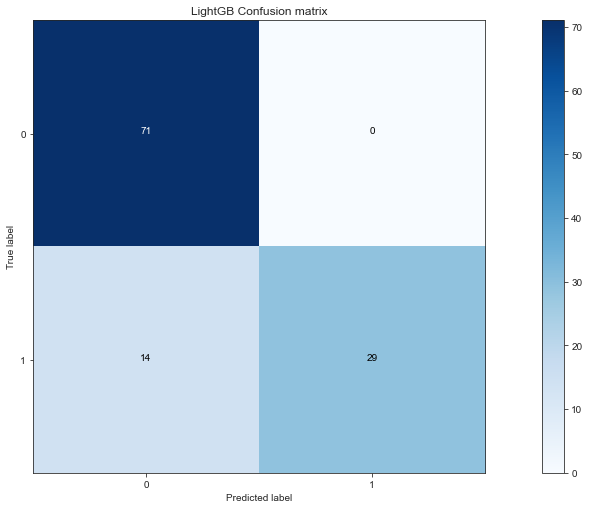

Accuracy  =     0.877
Misclassification =     85.483
Precision =     1.000
Recall    =     0.674
F1_score  =     0.806


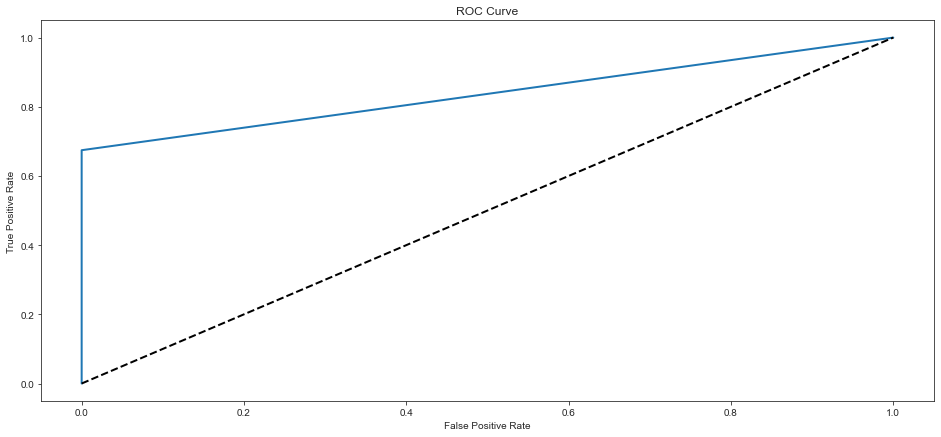

In [514]:
#Log with best hyperparameters
CV_model_lgb = lgb.LGBMClassifier(boosting_type='dart', colsample_bytree=0.64, learning_rate=0.01, max_bin=255,
                                  n_estimators=24, num_leaves=6, objective='binary', random_state=500, reg_alpha=1.2,
                                  reg_lambda=1, subsample=0.7)

CV_model_lgb.fit(X_train, y_train)
y_pred = CV_model_lgb.predict(X_test)
#y_score = CV_model_lgb.decision_function(X_test)

# Save accuracy score for summary display in section 9
acc_lgb =  metrics.accuracy_score(y_test, y_pred)

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cm,
                      classes=class_names,
                      title='LightGB Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_pred)
plot_roc()

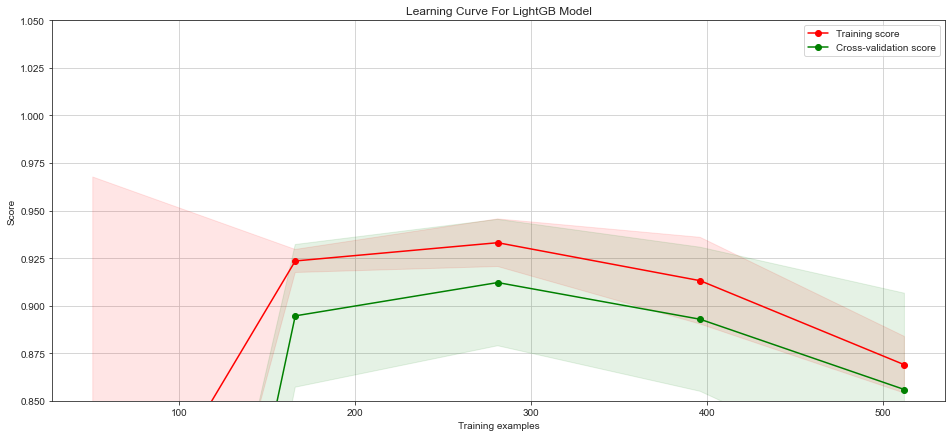

In [515]:
#Learning curve Log with best hyperparameters
plot_learning_curve(CV_model_lgb, 'Learning Curve For LightGB Model', X, y, (0.85, 1.05), 10)
plt.savefig('7')
plt.show()

In [516]:
# Cross val Log
cross_log = cross_val_metrics(CV_model_lgb)

[accuracy] : 0.85251 (+/- 0.04634)
[precision] : 1.00000 (+/- 0.00000)
[recall] : 0.60487 (+/- 0.12145)


In [517]:
# Pickle the model for later used
with open('lgb.pickle', 'wb') as f:
    pickle.dump(CV_model_lgb, f, pickle.HIGHEST_PROTOCOL)

## 8.8 Optimized AdaBoost using GridSearchCV

In [518]:
# Find best hyperparameters
model_ada = AdaBoostClassifier(random_state=random_state)
param_grid = {"n_estimators": [1, 10, 50, 100, 200, 300, 400, 500, 600]}

CV_model_ada = GridSearchCV(estimator=model_ada, param_grid=param_grid, scoring='accuracy', verbose=1, n_jobs=-1,
                            error_score='raise')
CV_model_ada.fit(X_train, y_train)

best_parameters = CV_model_ada.best_params_
print('The best parameters for using AdaBoost model is: ', best_parameters)
print('The best score for using AdaBoost model is: ', CV_model_ada.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
The best parameters for using AdaBoost model is:  {'n_estimators': 200}
The best score for using AdaBoost model is:  0.9670329670329669


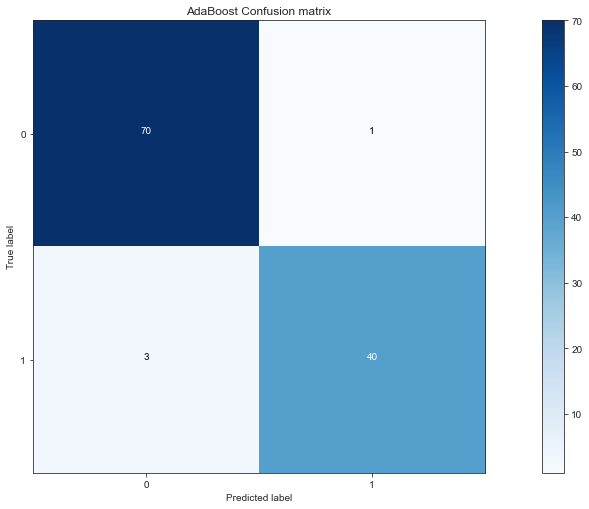

Accuracy  =     0.965
Misclassification =     75.075
Precision =     0.976
Recall    =     0.930
F1_score  =     0.952


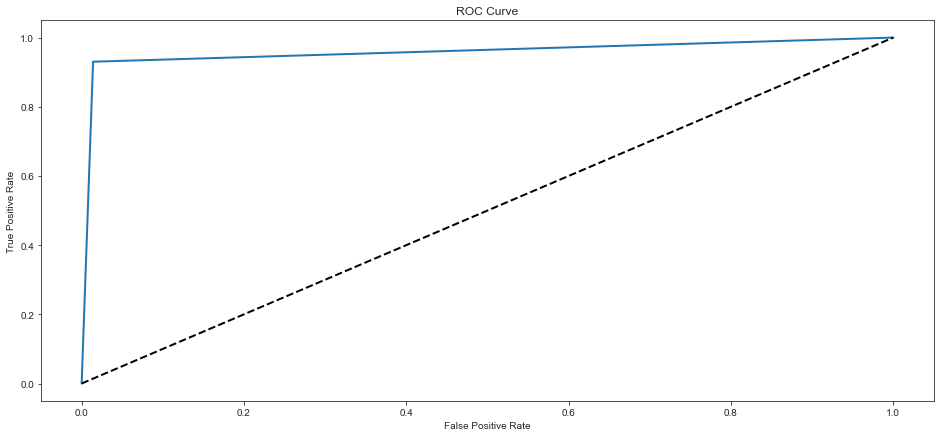

In [519]:
#Log with best hyperparameters
CV_model_ada = AdaBoostClassifier(n_estimators=200)

CV_model_ada.fit(X_train, y_train)
y_pred = CV_model_ada.predict(X_test)
y_score = CV_model_ada.decision_function(X_test)

# Save accuracy score for summary display in section 9
acc_adaboost =  metrics.accuracy_score(y_test, y_pred)

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cm,
                      classes=class_names,
                      title='AdaBoost Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_pred)
plot_roc()

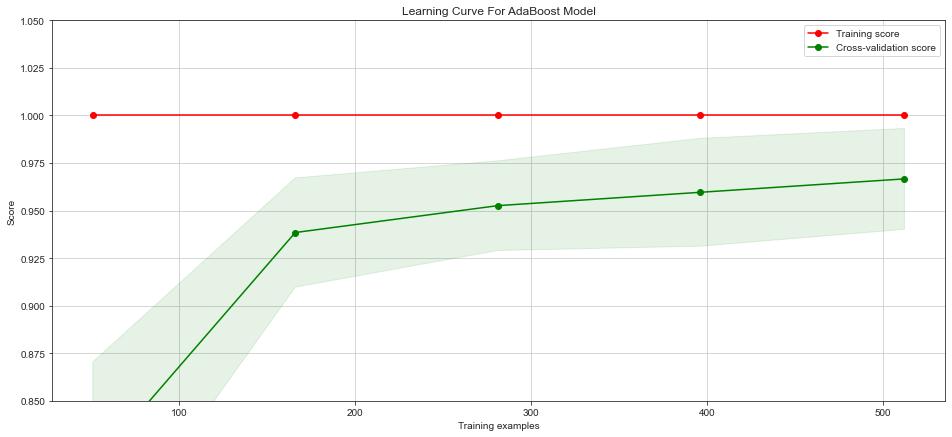

In [520]:
#Learning curve Log with best hyperparameters
plot_learning_curve(CV_model_ada, 'Learning Curve For AdaBoost Model', X, y, (0.85, 1.05), 10)
plt.savefig('7')
plt.show()

In [521]:
# Cross val Log
cross_log = cross_val_metrics(CV_model_ada)

[accuracy] : 0.96665 (+/- 0.01507)
[precision] : 0.96632 (+/- 0.01917)
[recall] : 0.94828 (+/- 0.02256)


In [522]:
# Pickle the model for later used
with open('ada.pickle', 'wb') as f:
    pickle.dump(CV_model_ada, f, pickle.HIGHEST_PROTOCOL)

## 8.9 Optimized XGBoost using GridSearchCV

In [523]:
# Find best hyperparameters
model_xgb = XGBClassifier(random_state=random_state)
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100]}

CV_model_xgb = GridSearchCV(estimator=model_xgb, param_grid=param_grid, scoring='accuracy', verbose=1, n_jobs=-1,
                            error_score='raise')
CV_model_xgb.fit(X_train, y_train)

best_parameters = CV_model_xgb.best_params_
print('The best parameters for using XGBoost model is: ', best_parameters)
print('The best score for using XGBoost model is: ', CV_model_xgb.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best parameters for using XGBoost model is:  {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
The best score for using XGBoost model is:  0.9626373626373625


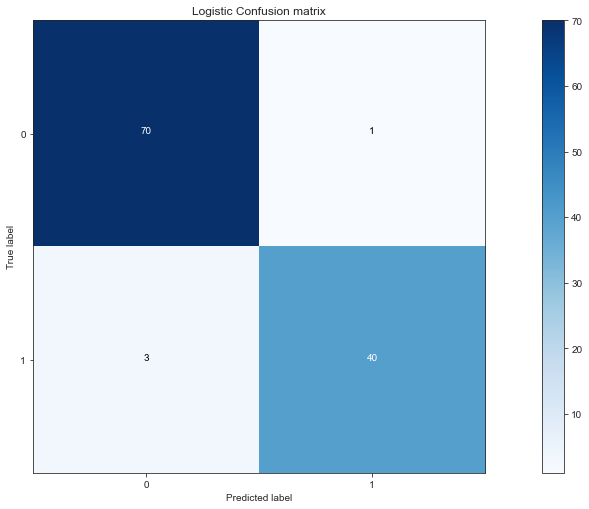

Accuracy  =     0.965
Misclassification =     75.075
Precision =     0.976
Recall    =     0.930
F1_score  =     0.952


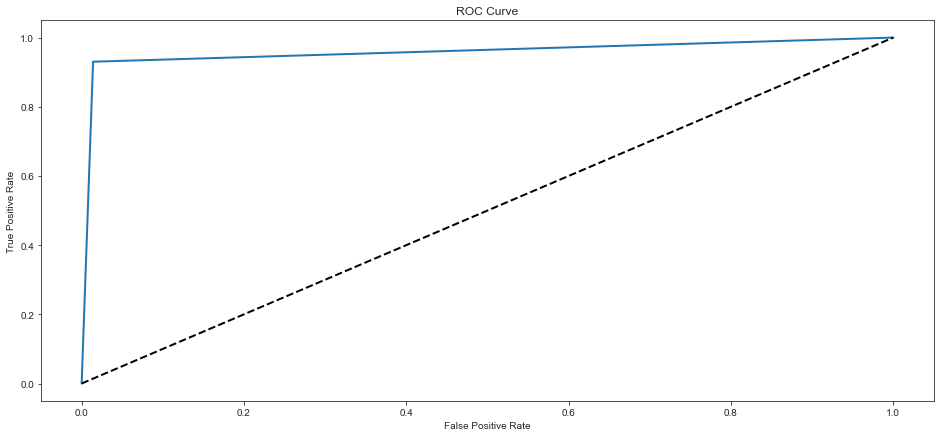

In [524]:
#Log with best hyperparameters
CV_model_xgb = XGBClassifier(learning_rate=0.2, max_depth=3, n_estimators=100)

CV_model_xgb.fit(X_train, y_train)
y_pred = CV_model_xgb.predict(X_test)

# Save accuracy score for summary display in section 9
acc_xgboost =  metrics.accuracy_score(y_test, y_pred)

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cm,
                      classes=class_names,
                      title='Logistic Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_pred)
plot_roc()

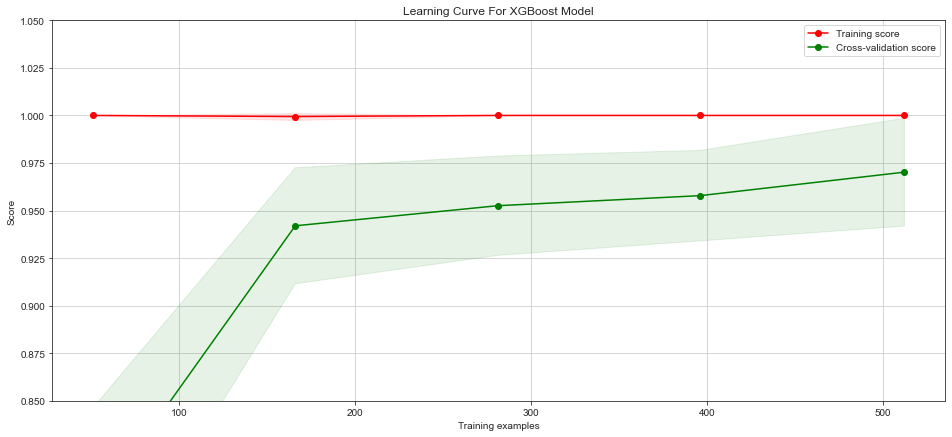

In [525]:
#Learning curve Log with best hyperparameters
plot_learning_curve(CV_model_xgb, 'Learning Curve For XGBoost Model', X, y, (0.85, 1.05), 10)
plt.savefig('7')
plt.show()

In [526]:
# Cross val Log
cross_log = cross_val_metrics(CV_model_xgb)

[accuracy] : 0.97014 (+/- 0.01527)
[precision] : 0.96267 (+/- 0.02367)
[recall] : 0.95781 (+/- 0.02709)


In [527]:
# Pickle the model for later used
with open('xgb.pickle', 'wb') as f:
    pickle.dump(CV_model_xgb, f, pickle.HIGHEST_PROTOCOL)

## 8.10 Optimized CatBoost using GridSearchCV

In [528]:
# Find best hyperparameters
model_cat = CatBoostClassifier(random_state=random_state)
param_grid = {'depth': [4, 5, 6, 7, 8, 9, 10],
              'learning_rate': [0.01, 0.02, 0.03, 0.04],
              'iterations': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
              }

CV_model_cat = GridSearchCV(estimator=model_cat, param_grid=param_grid, scoring='accuracy', verbose=1, n_jobs=-1,
                            error_score='raise', cv=2)
CV_model_cat.fit(X_train, y_train)

best_parameters = CV_model_cat.best_params_
print('The best parameters for using CatBoost model is: ', best_parameters)
print('The best score for using CatBoost model is: ', CV_model_cat.best_score_)

Fitting 2 folds for each of 280 candidates, totalling 560 fits
0:	learn: 0.6762336	total: 58.3ms	remaining: 2.27s
1:	learn: 0.6607574	total: 117ms	remaining: 2.22s
2:	learn: 0.6469577	total: 174ms	remaining: 2.14s
3:	learn: 0.6345852	total: 231ms	remaining: 2.08s
4:	learn: 0.6200628	total: 291ms	remaining: 2.03s
5:	learn: 0.6070905	total: 366ms	remaining: 2.07s
6:	learn: 0.5946086	total: 448ms	remaining: 2.11s
7:	learn: 0.5822421	total: 510ms	remaining: 2.04s
8:	learn: 0.5695628	total: 578ms	remaining: 1.99s
9:	learn: 0.5595161	total: 639ms	remaining: 1.92s
10:	learn: 0.5469842	total: 701ms	remaining: 1.85s
11:	learn: 0.5369295	total: 763ms	remaining: 1.78s
12:	learn: 0.5264767	total: 838ms	remaining: 1.74s
13:	learn: 0.5161830	total: 917ms	remaining: 1.7s
14:	learn: 0.5070889	total: 979ms	remaining: 1.63s
15:	learn: 0.4972353	total: 1.04s	remaining: 1.57s
16:	learn: 0.4873468	total: 1.11s	remaining: 1.5s
17:	learn: 0.4778199	total: 1.17s	remaining: 1.43s
18:	learn: 0.4687332	total: 1.

0:	learn: 0.6784059	total: 64.4ms	remaining: 2.51s
1:	learn: 0.6633943	total: 121ms	remaining: 2.3s
2:	learn: 0.6494226	total: 179ms	remaining: 2.21s
3:	learn: 0.6349997	total: 235ms	remaining: 2.12s
4:	learn: 0.6195022	total: 317ms	remaining: 2.22s
5:	learn: 0.6046909	total: 388ms	remaining: 2.2s
6:	learn: 0.5918311	total: 445ms	remaining: 2.1s
7:	learn: 0.5801896	total: 505ms	remaining: 2.02s
8:	learn: 0.5682233	total: 562ms	remaining: 1.94s
9:	learn: 0.5572383	total: 632ms	remaining: 1.9s
10:	learn: 0.5472941	total: 694ms	remaining: 1.83s
11:	learn: 0.5373778	total: 753ms	remaining: 1.76s
12:	learn: 0.5267399	total: 833ms	remaining: 1.73s
13:	learn: 0.5173830	total: 904ms	remaining: 1.68s
14:	learn: 0.5069247	total: 968ms	remaining: 1.61s
15:	learn: 0.4979681	total: 1.03s	remaining: 1.54s
16:	learn: 0.4889055	total: 1.09s	remaining: 1.47s
17:	learn: 0.4796298	total: 1.15s	remaining: 1.41s
18:	learn: 0.4703692	total: 1.21s	remaining: 1.34s
19:	learn: 0.4620475	total: 1.27s	remaining:

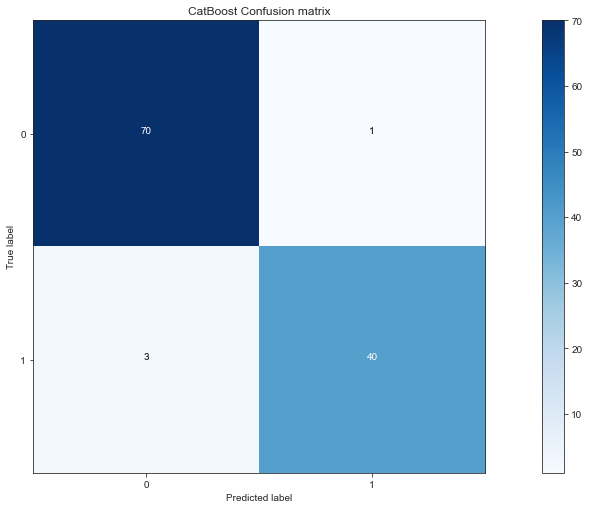

Accuracy  =     0.965
Misclassification =     75.075
Precision =     0.976
Recall    =     0.930
F1_score  =     0.952


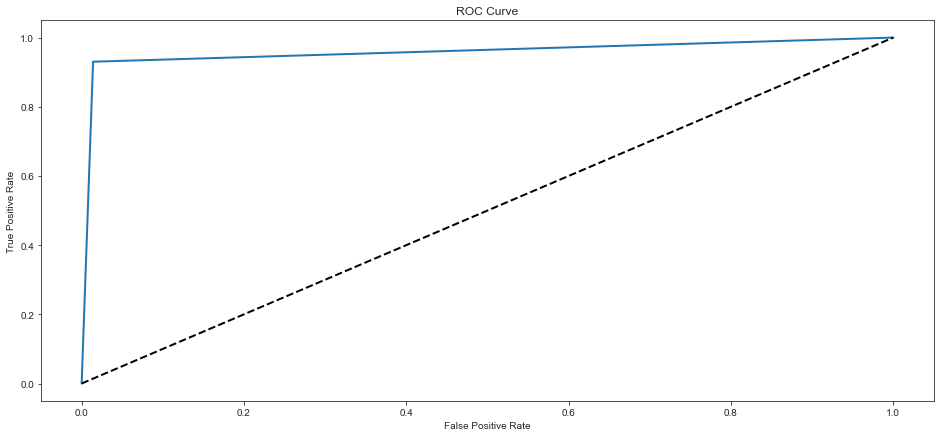

In [529]:
#Log with best hyperparameters
CV_model_cat = CatBoostClassifier(depth=10, iterations=40, learning_rate=0.03)

CV_model_cat.fit(X_train, y_train)
y_pred = CV_model_cat.predict(X_test)
#y_score = CV_model_cat.decision_function(X_test)

# Save accuracy score for summary display in section 9
acc_catboost = metrics.accuracy_score(y_test, y_pred)

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cm,
                      classes=class_names,
                      title='CatBoost Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_pred)
plot_roc()

0:	learn: 0.6833868	total: 4.1ms	remaining: 160ms
1:	learn: 0.6743784	total: 5.46ms	remaining: 104ms
2:	learn: 0.6660672	total: 7.27ms	remaining: 89.7ms
3:	learn: 0.6597655	total: 17.5ms	remaining: 157ms
4:	learn: 0.6532704	total: 20.5ms	remaining: 144ms
5:	learn: 0.6468898	total: 30.5ms	remaining: 173ms
6:	learn: 0.6429425	total: 41ms	remaining: 193ms
7:	learn: 0.6341702	total: 43ms	remaining: 172ms
8:	learn: 0.6293218	total: 52.8ms	remaining: 182ms
9:	learn: 0.6235623	total: 58.1ms	remaining: 174ms
10:	learn: 0.6180828	total: 68.5ms	remaining: 181ms
11:	learn: 0.6102674	total: 78.7ms	remaining: 184ms
12:	learn: 0.6045134	total: 88.7ms	remaining: 184ms
13:	learn: 0.6009052	total: 99.2ms	remaining: 184ms
14:	learn: 0.5908252	total: 102ms	remaining: 171ms
15:	learn: 0.5783196	total: 103ms	remaining: 154ms
16:	learn: 0.5728945	total: 113ms	remaining: 153ms
17:	learn: 0.5627304	total: 116ms	remaining: 142ms
18:	learn: 0.5558664	total: 127ms	remaining: 141ms
19:	learn: 0.5528364	total: 140

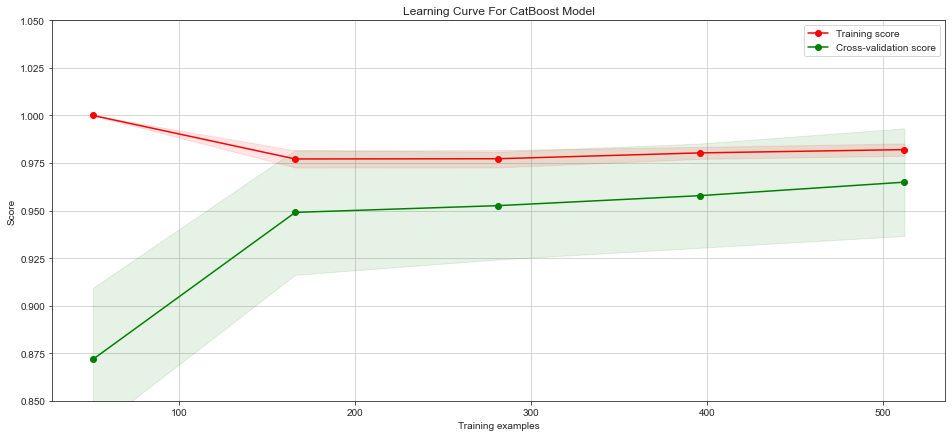

In [530]:
#Learning curve Log with best hyperparameters
plot_learning_curve(CV_model_cat, 'Learning Curve For CatBoost Model', X, y, (0.85, 1.05), 10)
plt.savefig('7')
plt.show()

In [531]:
# Cross val Log
cross_log = cross_val_metrics(CV_model_cat)

0:	learn: 0.6784761	total: 104ms	remaining: 4.05s
1:	learn: 0.6593687	total: 187ms	remaining: 3.55s
2:	learn: 0.6455675	total: 280ms	remaining: 3.45s
3:	learn: 0.6318884	total: 379ms	remaining: 3.41s
4:	learn: 0.6161427	total: 448ms	remaining: 3.14s
5:	learn: 0.6016861	total: 517ms	remaining: 2.93s
6:	learn: 0.5885794	total: 585ms	remaining: 2.76s
7:	learn: 0.5766757	total: 781ms	remaining: 3.12s
8:	learn: 0.5651477	total: 883ms	remaining: 3.04s
9:	learn: 0.5534156	total: 963ms	remaining: 2.89s
10:	learn: 0.5434884	total: 1.05s	remaining: 2.77s
11:	learn: 0.5332487	total: 1.23s	remaining: 2.88s
12:	learn: 0.5225356	total: 1.32s	remaining: 2.74s
13:	learn: 0.5134952	total: 1.41s	remaining: 2.61s
14:	learn: 0.5016053	total: 1.48s	remaining: 2.46s
15:	learn: 0.4928531	total: 1.57s	remaining: 2.36s
16:	learn: 0.4834722	total: 1.66s	remaining: 2.25s
17:	learn: 0.4733424	total: 1.74s	remaining: 2.12s
18:	learn: 0.4638548	total: 1.81s	remaining: 2s
19:	learn: 0.4551111	total: 1.87s	remaining:

In [532]:
# Pickle the model for later used
with open('cat.pickle', 'wb') as f:
    pickle.dump(CV_model_cat, f, pickle.HIGHEST_PROTOCOL)

## 8.11 Optimized Naive Bayes using GridSearchCV

In [533]:
# Find best hyperparameters
model_nb = GaussianNB()
param_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

CV_model_nb = GridSearchCV(estimator=model_nb, param_grid=param_grid, scoring='accuracy', verbose=1, n_jobs=-1,
                           error_score='raise')
CV_model_nb.fit(X_train, y_train)

best_parameters = CV_model_nb.best_params_
print('The best parameters for using Naive Bayes model is: ', best_parameters)
print('The best score for using Naive Bayes model is: ', CV_model_nb.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
The best parameters for using Naive Bayes model is:  {'var_smoothing': 0.1}
The best score for using Naive Bayes model is:  0.9318681318681319


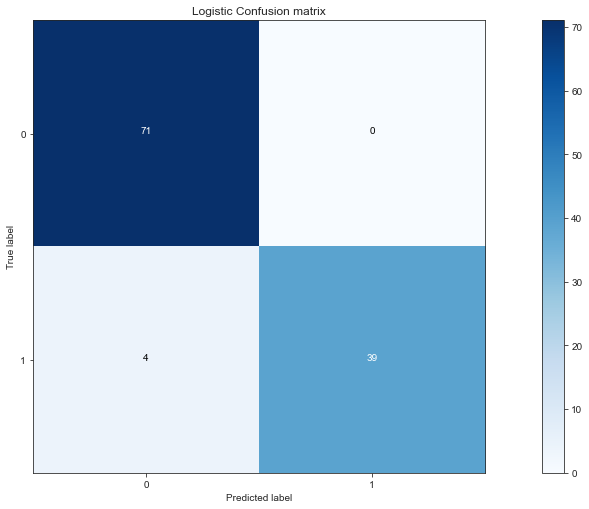

Accuracy  =     0.965
Misclassification =     75.103
Precision =     1.000
Recall    =     0.907
F1_score  =     0.951


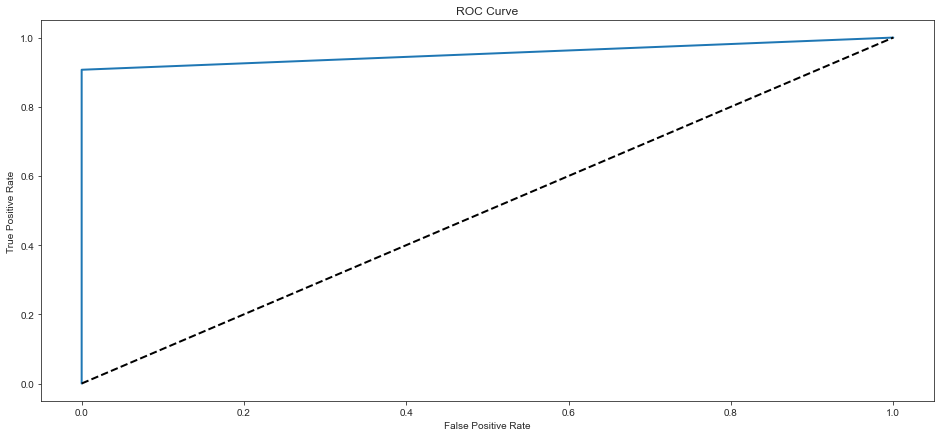

In [534]:
#Log with best hyperparameters
CV_model_nb = GaussianNB(var_smoothing=0.1)

CV_model_nb.fit(X_train, y_train)
y_pred = CV_model_nb.predict(X_test)
#y_score = CV_model_nb.decision_function(X_test)

# Save accuracy score for summary display in section 9
acc_nb = metrics.accuracy_score(y_test, y_pred)

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cm,
                      classes=class_names,
                      title='Logistic Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_pred)
plot_roc()

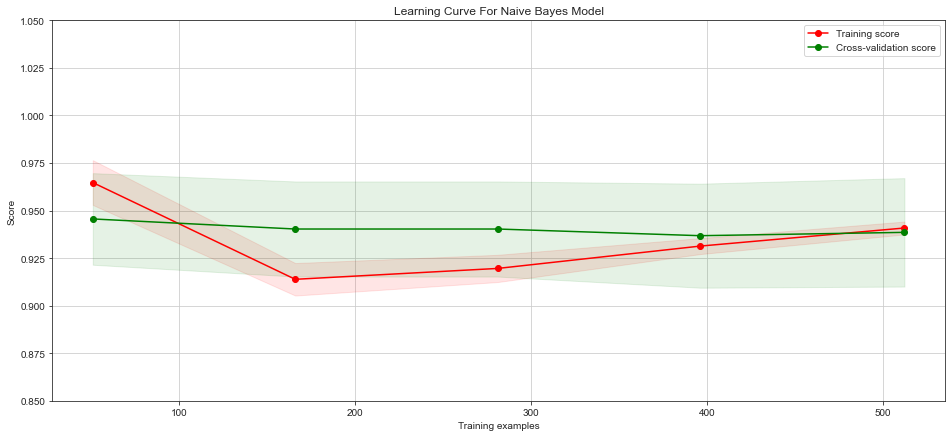

In [535]:
#Learning curve Log with best hyperparameters
plot_learning_curve(CV_model_nb, 'Learning Curve For Naive Bayes Model', X, y, (0.85, 1.05), 10)
plt.savefig('7')
plt.show()

In [536]:
# Cross val Log
cross_log = cross_val_metrics(CV_model_nb)

[accuracy] : 0.93852 (+/- 0.02213)
[precision] : 0.96388 (+/- 0.02562)
[recall] : 0.86844 (+/- 0.04922)


In [537]:
# Pickle the model for later used
with open('nb.pickle', 'wb') as f:
    pickle.dump(CV_model_nb, f, pickle.HIGHEST_PROTOCOL)

# 9. Displaying Best Optimized Model

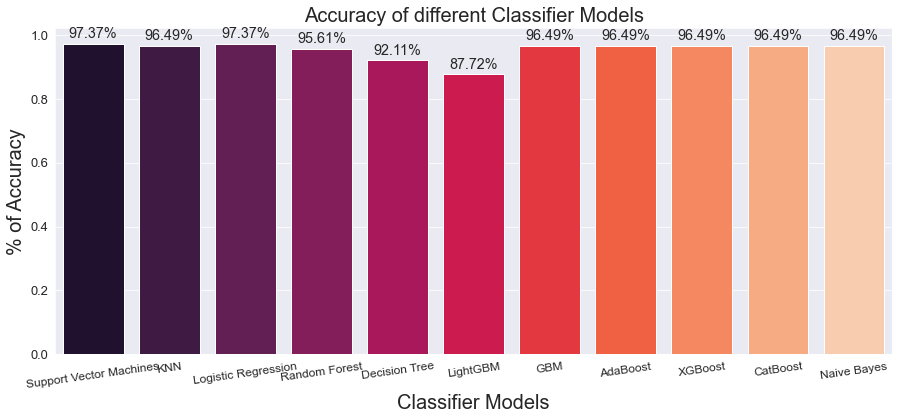

In [538]:
plot_accuracy(['Support Vector Machines', 'KNN', 'Logistic Regression',
              'Random Forest', 'Decision Tree', 'LightGBM', 'GBM', 'AdaBoost',
              'XGBoost', 'CatBoost', 'Naive Bayes'],
              [acc_svm, acc_knn, acc_logreg, acc_randomforest, acc_dt, acc_lgb,
              acc_gbm, acc_adaboost, acc_xgboost, acc_catboost, acc_nb])

# Interpretations and recommendations

# Future Work